In [1]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

## Simulation 1a

### Dataset

For each covariance in a list of different covariances between graph pairs, we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

### Model

1) $\textbf{Spectrum}$: For each pair of graphs, compute the spectral radii for each adjacency matrix individually, and compute the Spearman's rank correlation between the spectral radiis for each graph.

2) $\textbf{SDNE}$: For each epoch, for each pair of graphs, compute the embeddings using the SDNE (autoencoder), and compute the Spearman's rank correlation between the vectorial version of the embeddings of each graph.


In [6]:
dataset = "simulation1a"
models = os.listdir(os.path.join(outputs_path, dataset))
all_test_data = []
agg_metrics = []
all_metrics_by_true_cov = []
all_diff_by_true_cov = []
for model in models:

    if 'spectrum' in model:
        data = load_pickle(os.path.join(outputs_path, dataset, model, 'results.pkl'))
        test_data = data["train_test_results"]
    else:
        data = load_pickle(os.path.join(outputs_path, dataset, model, 'predictions.pkl'))
        test_data = data["test_predictions"]

    if len(test_data.shape) > 2:
        test_data_df = []
        for i in range(test_data.shape[0]):
            simulation_test_data = test_data[i, :, :]
            simulation_test_data_df = pd.DataFrame(simulation_test_data.numpy(), columns=["pred", "true"])
            simulation_test_data_df.loc[:, "simulation"] = i

            test_data_df.append(simulation_test_data_df)
        test_data_df = pd.concat(test_data_df, axis=0)
        test_data_df.loc[:, "true"] = [round(x, 2) for x in test_data_df["true"]]
        test_data_df.loc[:, "model"] = model
    else:
        test_data_df = pd.DataFrame(test_data.numpy(), columns=["pred", "true"])
        test_data_df.loc[:, "true"] = [round(x, 2) for x in test_data_df["true"]]
        test_data_df.loc[:, "model"] = model
    all_test_data.append(test_data_df)

    # compute aggregated mse and mae
    mse = mean_squared_error(test_data_df["true"], test_data_df["pred"])
    mae = mean_absolute_error(test_data_df["true"], test_data_df["pred"])
    agg_metrics.append({"model": model, "mse": mse, "mae": mae})

    # compute mse and mae per true cov
    metrics_by_true_cov = []
    for cov in test_data_df["true"].unique():
        selected_df = test_data_df.loc[test_data_df["true"] == cov]

        pred = selected_df["pred"]
        true = selected_df["true"]

        mse = mean_squared_error(true, pred)
        mae = mean_absolute_error(true, pred)
        metrics_by_true_cov.append({"model": model, "dataset": dataset, "cov": cov, "mse": mse, "mae": mae})
    metrics_by_true_cov_df = pd.DataFrame(metrics_by_true_cov)
    all_metrics_by_true_cov.append(metrics_by_true_cov_df)

    # compute diff by true cov
    diff_by_true_cov = []
    for cov in test_data_df["true"].unique():
        selected_df = test_data_df.loc[test_data_df["true"] == cov]

        pred = selected_df["pred"]
        true = selected_df["true"]

        selected_df.loc[:, "diff"] = true - pred
        diff_by_true_cov.append(selected_df)
    diff_by_true_cov_df = pd.concat(diff_by_true_cov, axis=0)
    all_diff_by_true_cov.append(diff_by_true_cov_df)

all_test_data_df = pd.concat(all_test_data, axis=0)
agg_metrics_df = pd.DataFrame(agg_metrics)
all_metrics_by_true_cov_df = pd.concat(all_metrics_by_true_cov, axis=0)
all_diff_by_true_cov_df = pd.concat(all_diff_by_true_cov, axis=0)

/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [4]:
parse_agg_metrics = []
for idx, row in agg_metrics_df.iterrows():
   model = row["model"].split("_")[0]
   
   if model.startswith("spectrum"):
       parse_agg_metrics.append({"model": model,
                                 "mse": row["mse"],
                                 "mae": row["mae"]})
   elif model.startswith('sae'):
        #model_name = f'{args.model_name}_{hidden_sizes_str}_{sparsity_penalty_scaled}_{dropout_scaled}_{int(args.epochs)}'
        epochs = row["model"].split("_")[-1]
        dropout = row["model"].split("_")[-2]
        sparsity = row["model"].split("_")[-3]
        hidden_layers = row["model"].split("_")[1:-4]

        parse_agg_metrics.append({"model": model,
                                  "dropout": dropout,
                                  "sparsity": sparsity,
                                  "hidden_layers": str(hidden_layers),
                                  "epochs": epochs,
                                  "mse": row["mse"],
                                  "mae": row["mae"]}
                                )

   elif model.startswith("sdne") or model.startswith("sgnn0"):
         n_hidden = row["model"].split("_")[1]
         n_layers_enc = row["model"].split("_")[2]
         n_layers_dec = row["model"].split("_")[3]
         epochs = row["model"].split("_")[4]
         parse_agg_metrics.append({"model": model,
                                   "n_hidden": n_hidden,
                                   "n_layers_enc": n_layers_enc,
                                   "n_layers_dec": n_layers_dec,
                                   "epochs": epochs,
                                   "mse": row["mse"],
                                   "mae": row["mae"]})
   else:
       raise ValueError(f"Model not recognized: {model}")
parse_agg_metrics_df = pd.DataFrame(parse_agg_metrics)

In [18]:
parse_agg_metrics_df.loc[parse_agg_metrics_df["model"] == "sgnn0"]

model n_hidden n_layers_enc n_layers_dec epochs       mse       mae  \
119  sgnn0   cosine      average    laplacian     15  0.278386  0.436638   

    dropout sparsity hidden_layers  
119     NaN      NaN           NaN

In [13]:
parse_agg_metrics_df.sort_values(by="mse").head(10)

model n_hidden n_layers_enc n_layers_dec  epochs       mse       mae  \
106  spectrum      NaN          NaN          NaN     NaN  0.010703  0.076728   
35      sdne6       40            1            1     100  0.054421  0.200445   
60      sdne3       50            1            1     100  0.057781  0.204753   
48      sdne4       40            1            1      10  0.058458  0.207825   
74      sdne3      100            1            1      10  0.060396  0.210284   
14      sdne6       40            1            1  100000  0.062557  0.214795   
57      sdne4       30            1            1     100  0.063452  0.216063   
65      sdne6       20            1            1      10  0.064533  0.218246   
55      sdne4       50            1            1      10  0.066645  0.222243   
7       sdne3      100            1            1  100000  0.067655  0.223398   

    dropout sparsity hidden_layers  
106     NaN      NaN           NaN  
35      NaN      NaN           NaN  
60      NaN      NaN           NaN  
48      NaN      NaN           NaN  
74      NaN      NaN           NaN  
14      NaN      NaN           NaN  
57      NaN      NaN           NaN  
65      NaN      NaN           NaN  
55      NaN      NaN           NaN  
7       NaN      NaN           NaN

In [14]:
parse_agg_metrics_df.sort_values(by="mae").head(20)

model n_hidden n_layers_enc n_layers_dec  epochs       mse       mae  \
106  spectrum      NaN          NaN          NaN     NaN  0.010703  0.076728   
35      sdne6       40            1            1     100  0.054421  0.200445   
60      sdne3       50            1            1     100  0.057781  0.204753   
48      sdne4       40            1            1      10  0.058458  0.207825   
74      sdne3      100            1            1      10  0.060396  0.210284   
14      sdne6       40            1            1  100000  0.062557  0.214795   
57      sdne4       30            1            1     100  0.063452  0.216063   
65      sdne6       20            1            1      10  0.064533  0.218246   
55      sdne4       50            1            1      10  0.066645  0.222243   
7       sdne3      100            1            1  100000  0.067655  0.223398   
10      sdne3       30            1            1     100  0.068747  0.225078   
110     sdne6       40            1            1      10  0.069187  0.225972   
37      sdne4      100            1            1     100  0.069329  0.226404   
85      sdne6      100            1            1      10  0.071200  0.226974   
94      sdne3      100            1            1     100  0.070464  0.228117   
101     sdne4       30            1            1      10  0.072247  0.229799   
3       sdne3       50            1            1      10  0.072722  0.231101   
38      sdne3       50            1            1  100000  0.073565  0.232865   
9       sdne4       40            1            1     100  0.074971  0.235355   
41      sdne6       30            1            1      10  0.076005  0.236287   

    dropout sparsity hidden_layers  
106     NaN      NaN           NaN  
35      NaN      NaN           NaN  
60      NaN      NaN           NaN  
48      NaN      NaN           NaN  
74      NaN      NaN           NaN  
14      NaN      NaN           NaN  
57      NaN      NaN           NaN  
65      NaN      NaN           NaN  
55      NaN      NaN           NaN  
7       NaN      NaN           NaN  
10      NaN      NaN           NaN  
110     NaN      NaN           NaN  
37      NaN      NaN           NaN  
85      NaN      NaN           NaN  
94      NaN      NaN           NaN  
101     NaN      NaN           NaN  
3       NaN      NaN           NaN  
38      NaN      NaN           NaN  
9       NaN      NaN           NaN  
41      NaN      NaN           NaN

In [15]:
parse_agg_metrics_df.loc[parse_agg_metrics_df["model"].isin(["sdne3", "sae"])&(parse_agg_metrics_df["n_layers_enc"] == "1")].sort_values(by="mse")

model n_hidden n_layers_enc n_layers_dec  epochs       mse       mae  \
60  sdne3       50            1            1     100  0.057781  0.204753   
74  sdne3      100            1            1      10  0.060396  0.210284   
7   sdne3      100            1            1  100000  0.067655  0.223398   
10  sdne3       30            1            1     100  0.068747  0.225078   
94  sdne3      100            1            1     100  0.070464  0.228117   
3   sdne3       50            1            1      10  0.072722  0.231101   
38  sdne3       50            1            1  100000  0.073565  0.232865   
82  sdne3       30            1            1      10  0.080547  0.244257   
1   sdne3       30            1            1  100000  0.111754  0.288385   
59  sdne3       40            1            1     100  0.116105  0.290928   
75  sdne3       20            1            1      10  0.121592  0.300021   
11  sdne3       20            1            1     100  0.133440  0.308161   
26  sdne3       40            1            1      10  0.156437  0.330729   

   dropout sparsity hidden_layers  
60     NaN      NaN           NaN  
74     NaN      NaN           NaN  
7      NaN      NaN           NaN  
10     NaN      NaN           NaN  
94     NaN      NaN           NaN  
3      NaN      NaN           NaN  
38     NaN      NaN           NaN  
82     NaN      NaN           NaN  
1      NaN      NaN           NaN  
59     NaN      NaN           NaN  
75     NaN      NaN           NaN  
11     NaN      NaN           NaN  
26     NaN      NaN           NaN

In [16]:
set(parse_agg_metrics_df.model)

{'sae',
 'sae0',
 'sae1',
 'sdne0',
 'sdne1',
 'sdne2',
 'sdne3',
 'sdne4',
 'sdne5',
 'sdne6',
 'sgnn0',
 'spectrum'}

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_32455/1537379768.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


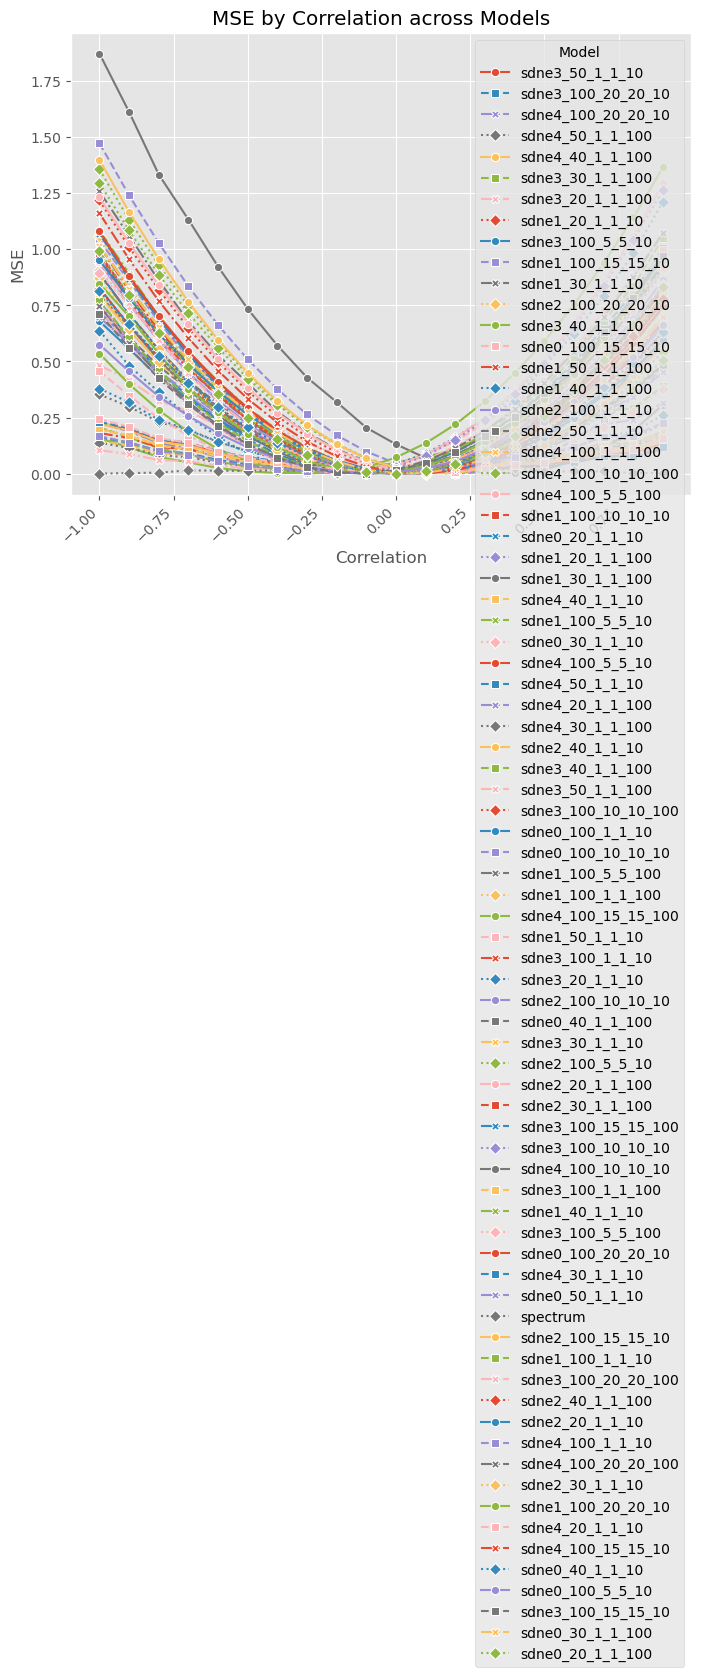

In [22]:
# Define unique line styles and markers for each model, ensure there are enough styles for each model
styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'X', 'D']

plt.figure(figsize=(8, 6))  # Create a figure for the plots

# Get the unique models
unique_models = all_metrics_by_true_cov_df["model"].unique()

# Iterate through each unique model and plot on the same graph with a unique style
for idx, model in enumerate(unique_models):
    # Filter the DataFrame for the current model
    model_df = all_metrics_by_true_cov_df[all_metrics_by_true_cov_df["model"] == model]
    
    # Plot the lineplot on the same figure with unique style and marker
    sns.lineplot(
        x='cov', y='mse', data=model_df,
        label=model, linestyle=styles[idx % len(styles)], marker=markers[idx % len(markers)]
    )

plt.title('MSE by Correlation across Models')  # Set the title for the entire plot
plt.xlabel('Correlation')  # Set the x-axis label
plt.ylabel('MSE')  # Set the y-axis label
plt.legend(title='Model')  # Enable the legend to distinguish models

# Rotate x labels for better fit
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# Define unique line styles and markers for each model, ensure there are enough styles for each model
styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'X', 'D']

plt.figure(figsize=(8, 6))  # Create a figure for the plots

# Get the unique models
unique_models = all_metrics_by_true_cov_df["model"].unique()

# Iterate through each unique model and plot on the same graph with a unique style
for idx, model in enumerate(unique_models):
    # Filter the DataFrame for the current model
    model_df = all_metrics_by_true_cov_df[all_metrics_by_true_cov_df["model"] == model]
    
    # Plot the lineplot on the same figure with unique style and marker
    sns.lineplot(
        x='cov', y='mae', data=model_df,
        label=model, linestyle=styles[idx % len(styles)], marker=markers[idx % len(markers)]
    )

plt.title('MAE by Correlation across Models')  # Set the title for the entire plot
plt.xlabel('Correlation')  # Set the x-axis label
plt.ylabel('MAE')  # Set the y-axis label
plt.legend(title='Model')  # Enable the legend to distinguish models

# Rotate x labels for better fit
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_32455/260458735.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


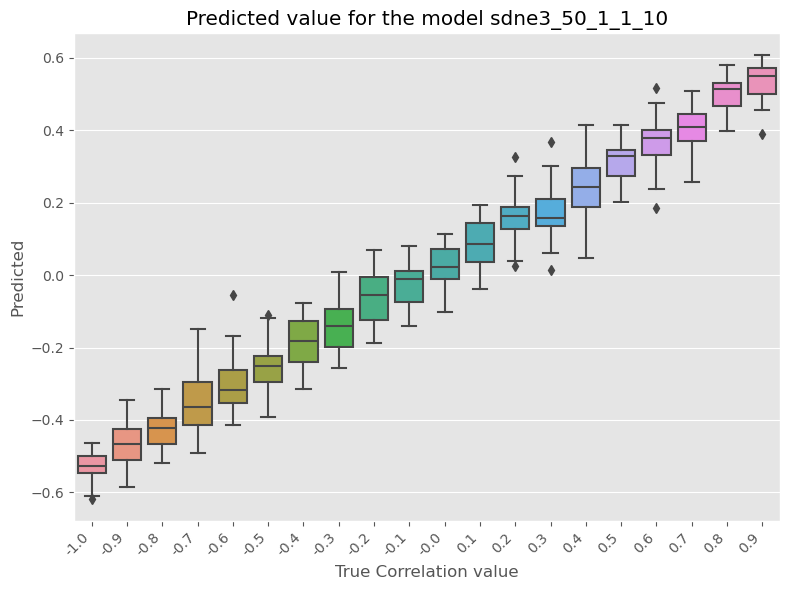

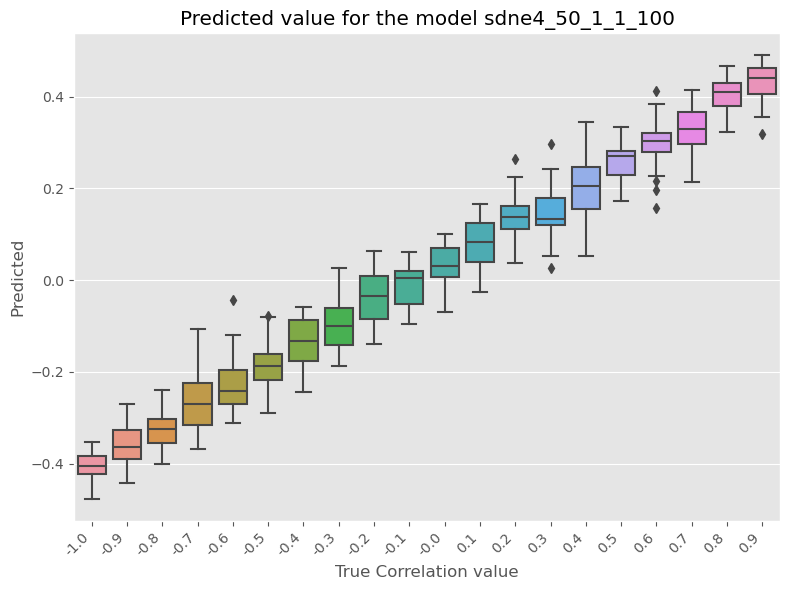

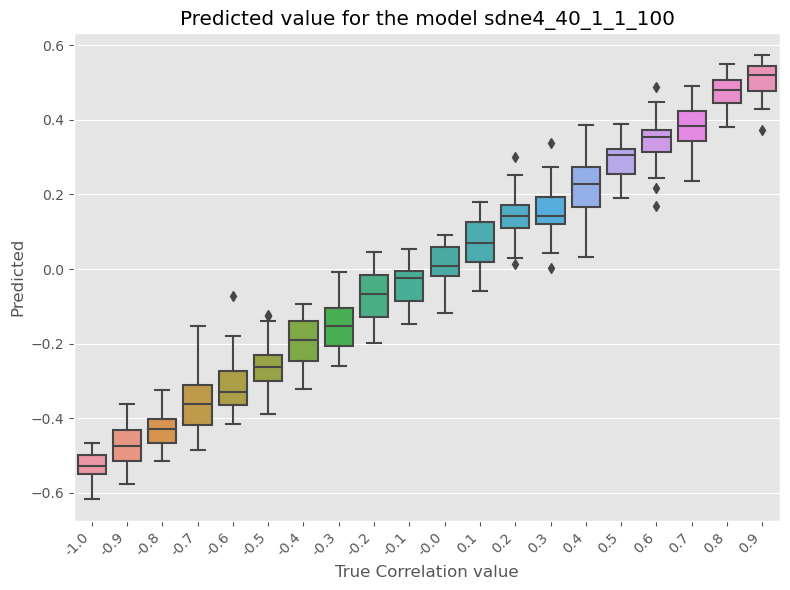

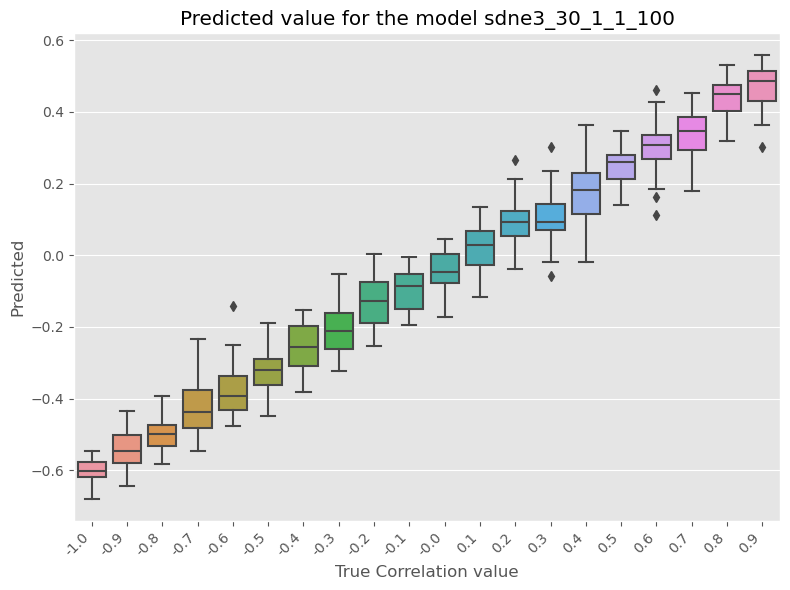

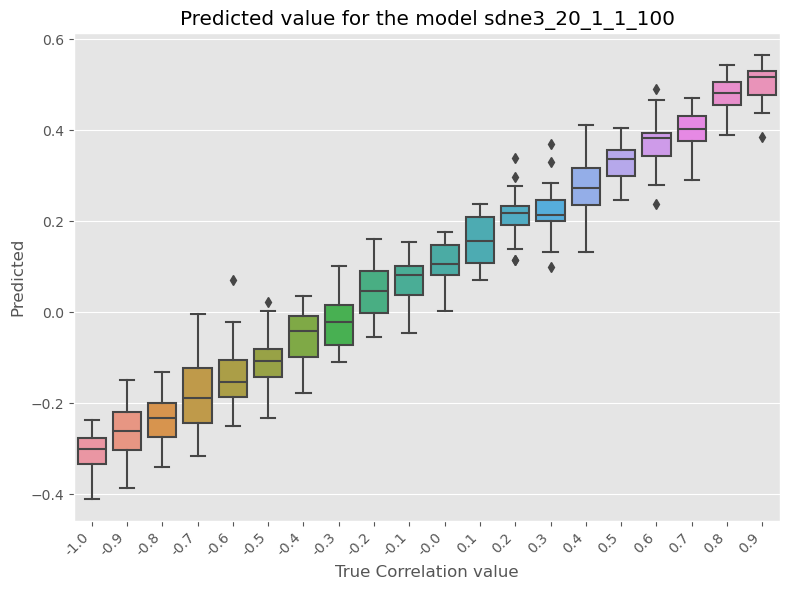

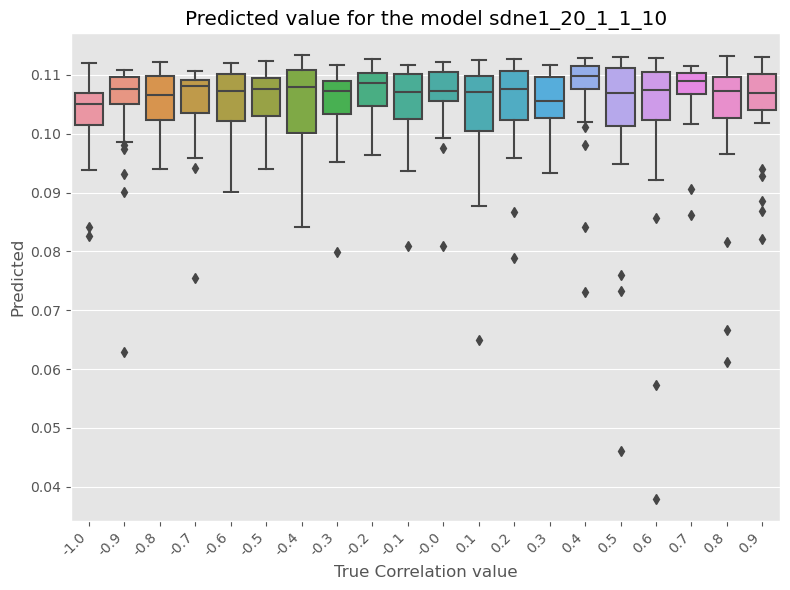

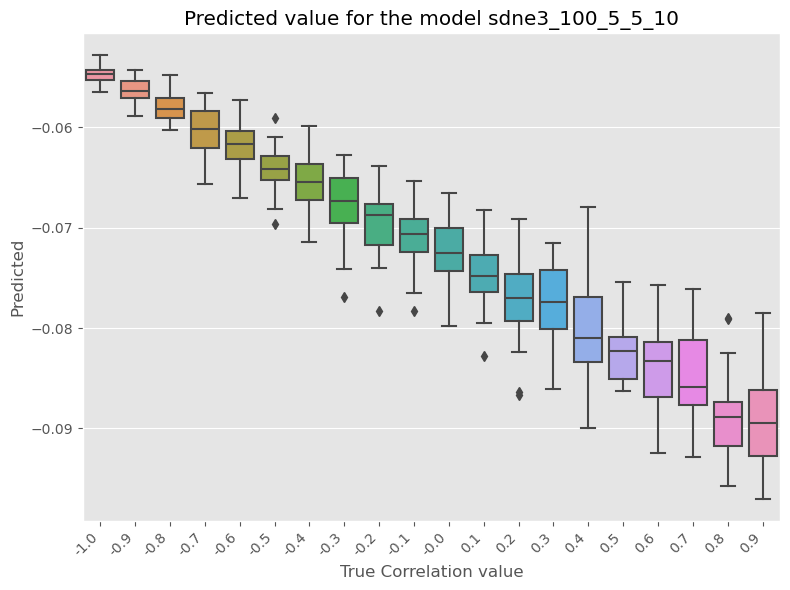

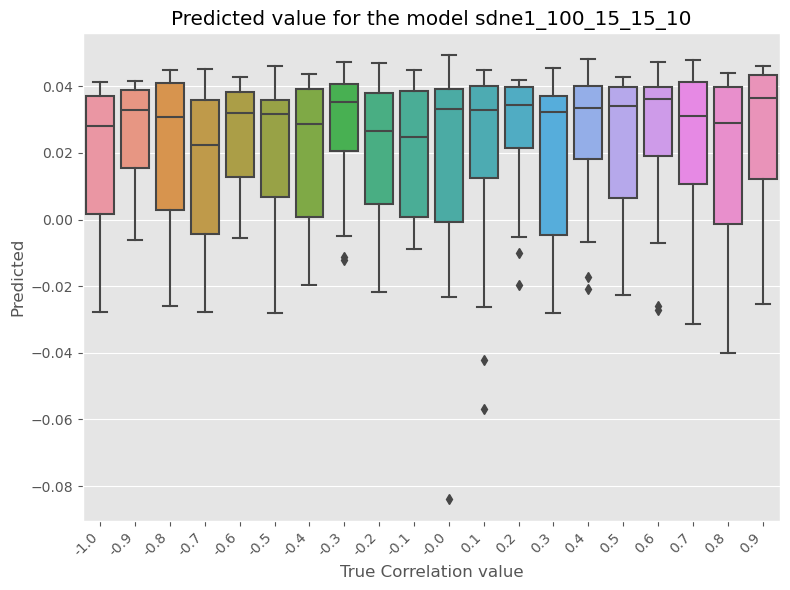

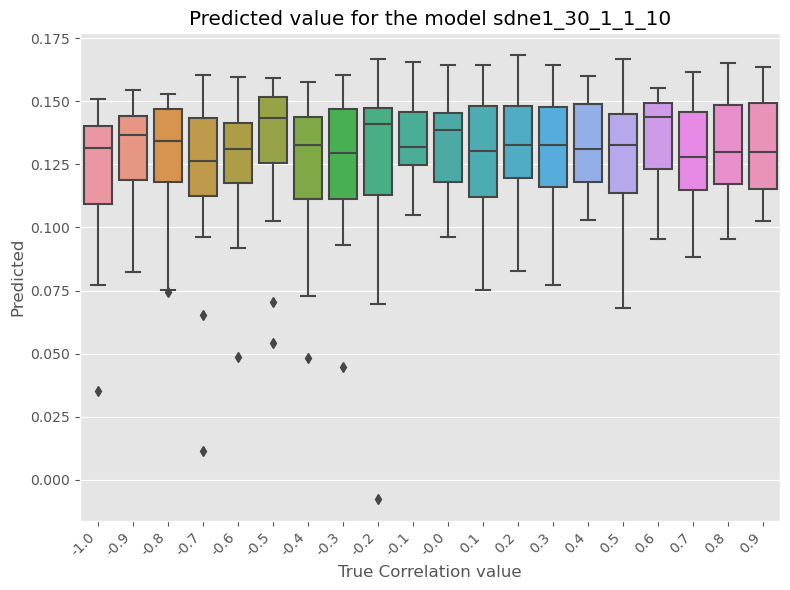

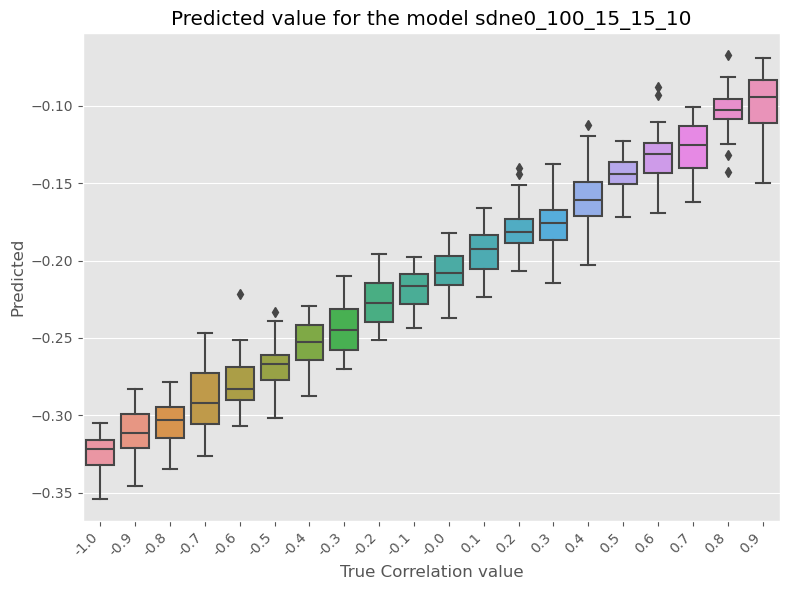

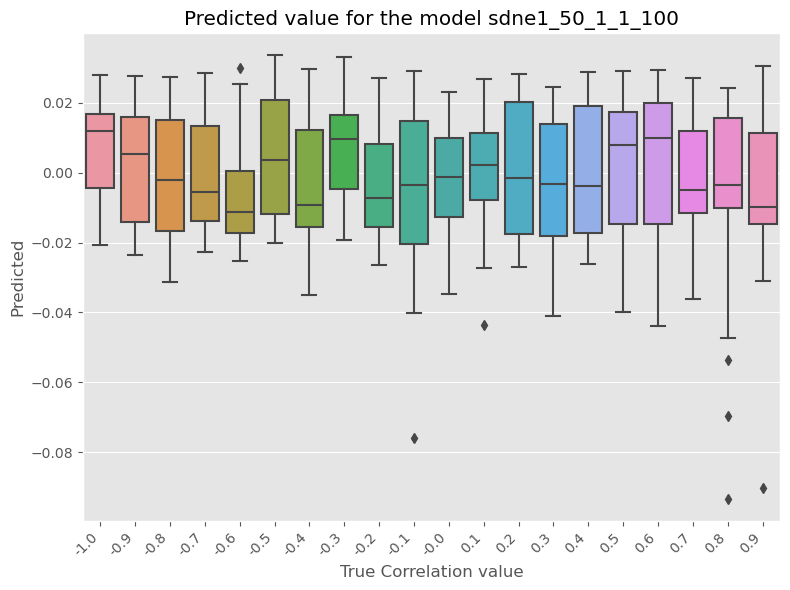

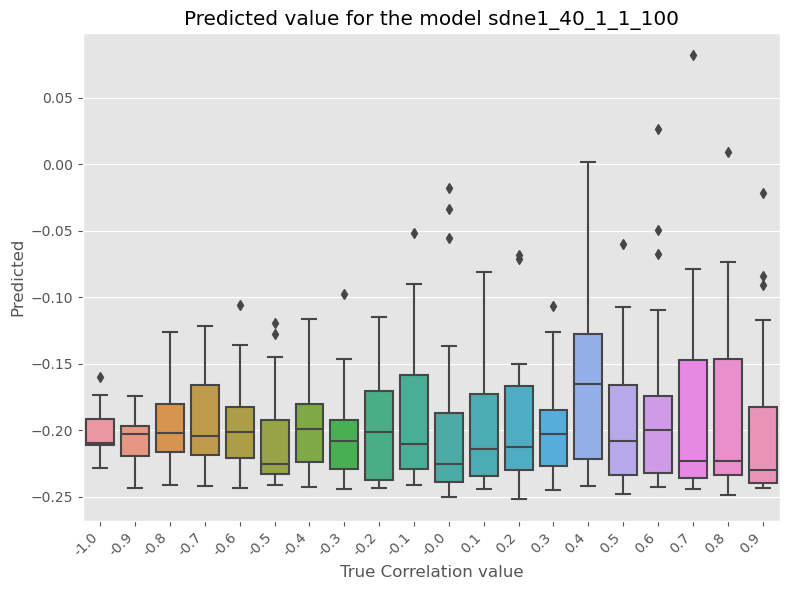

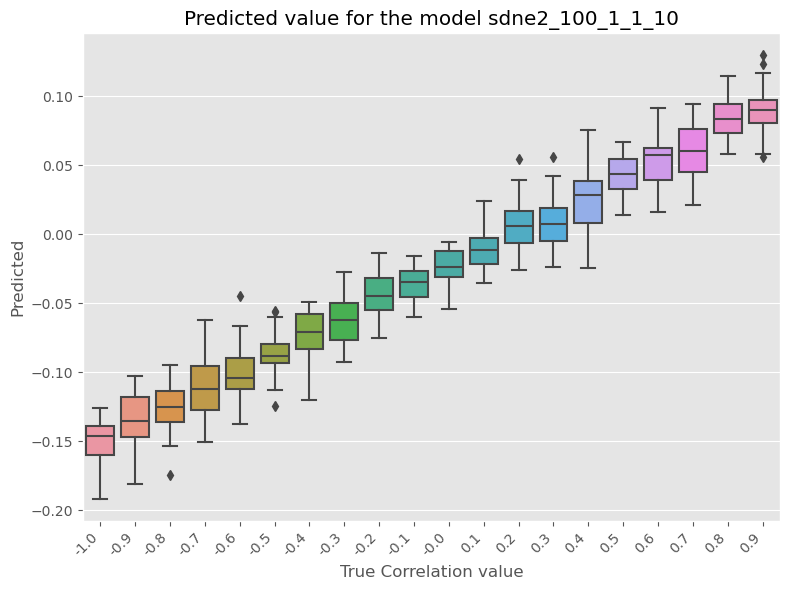

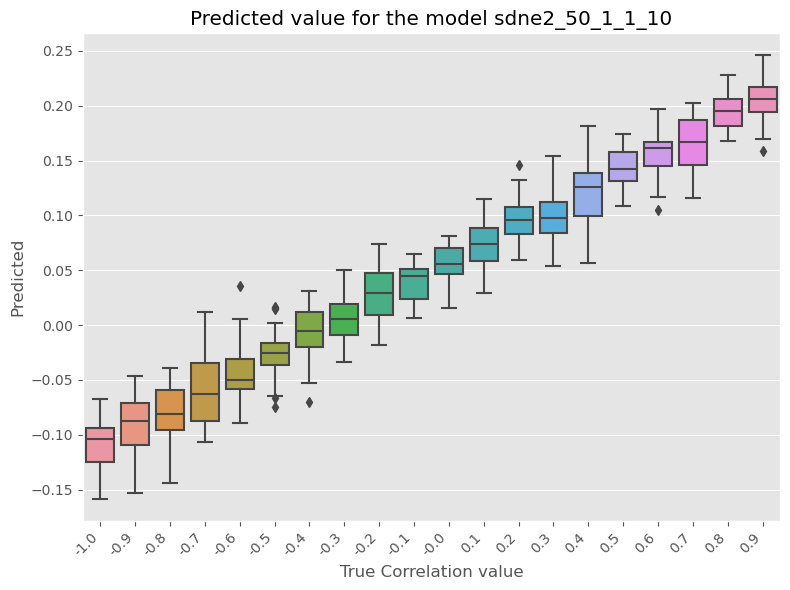

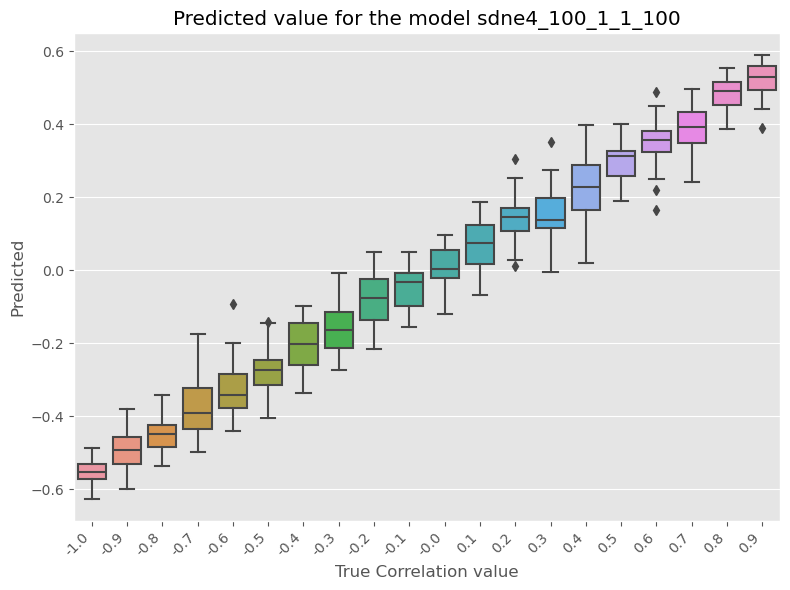

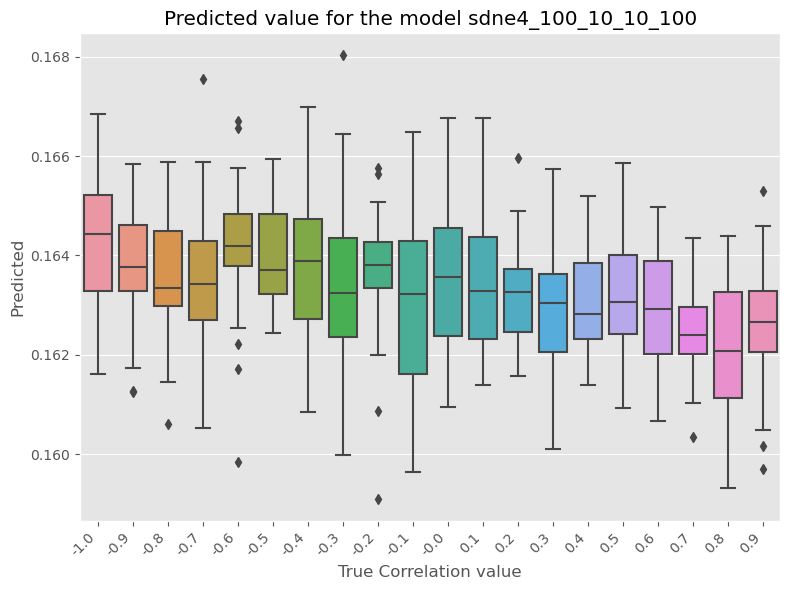

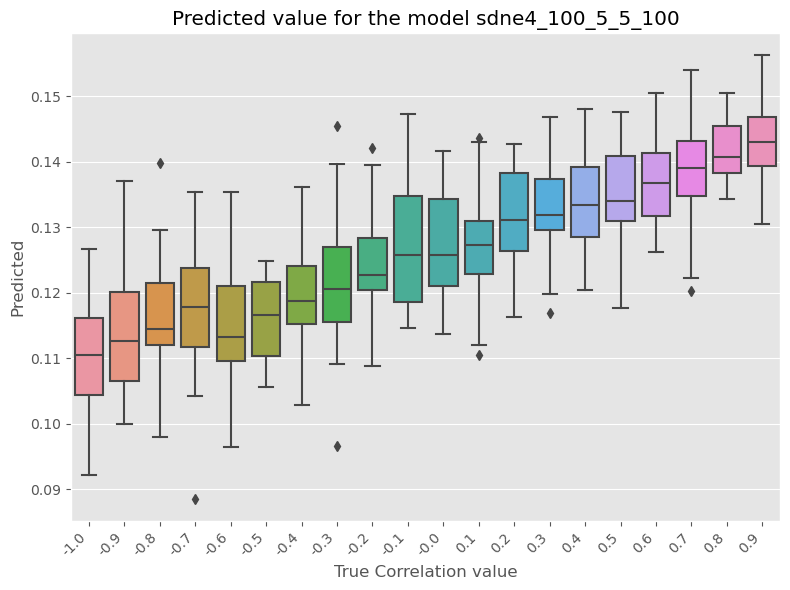

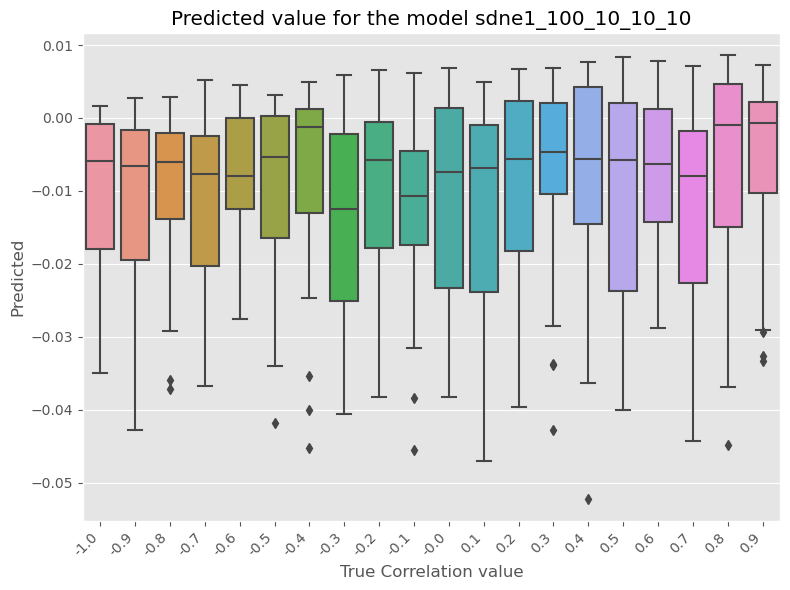

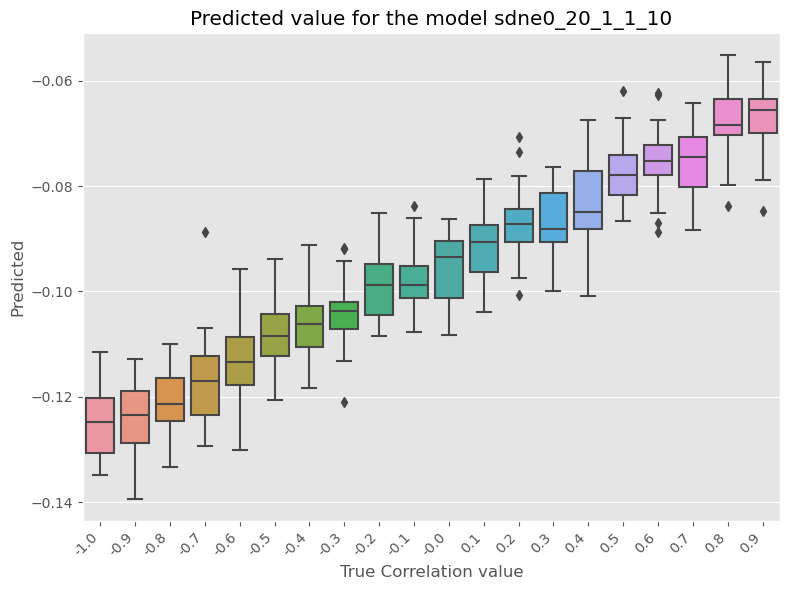

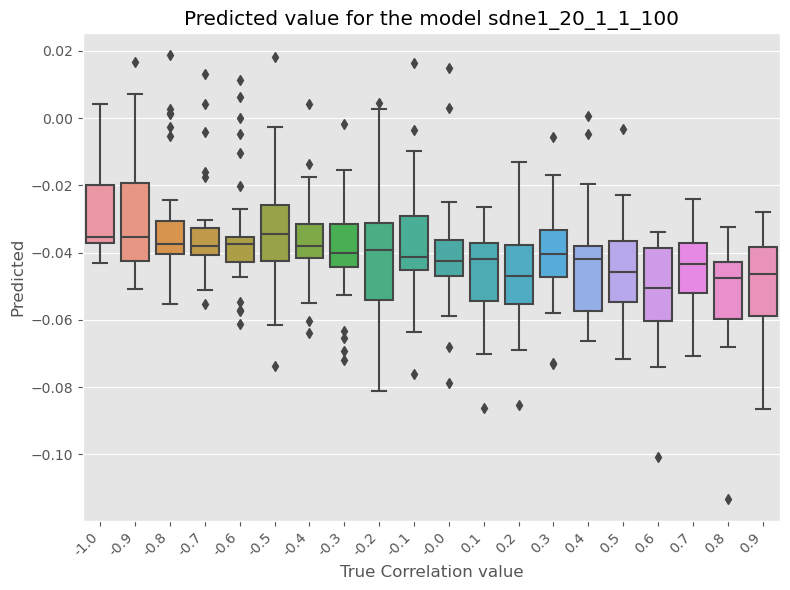

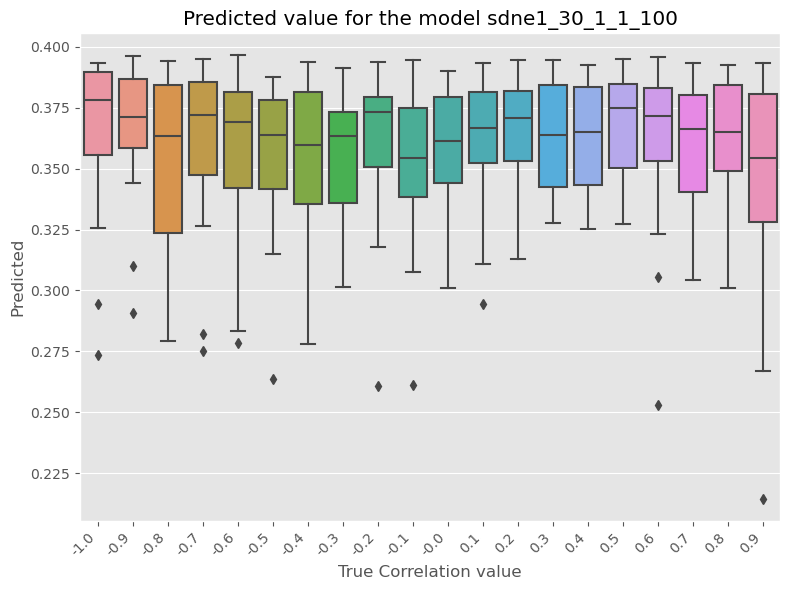

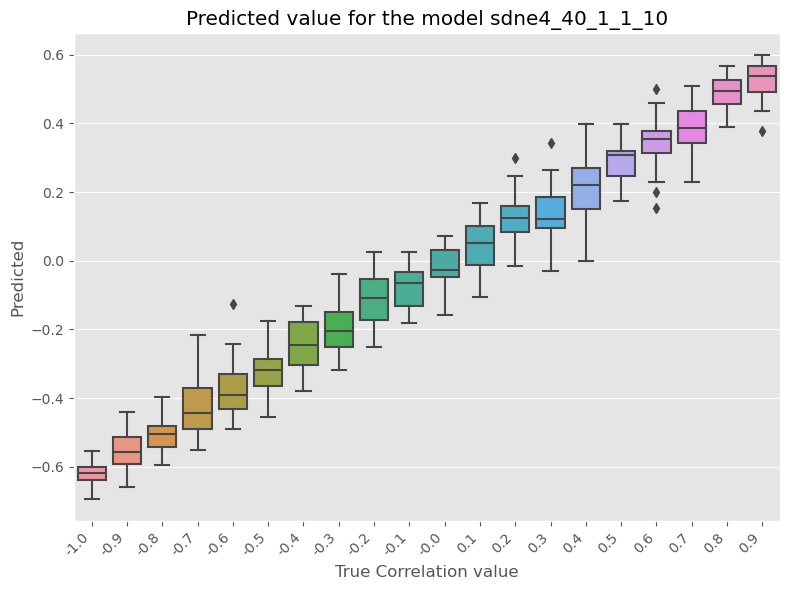

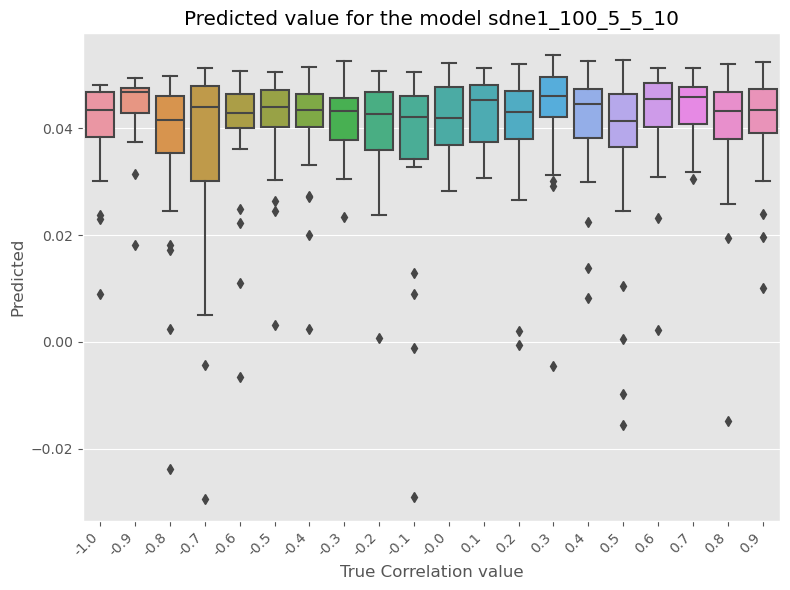

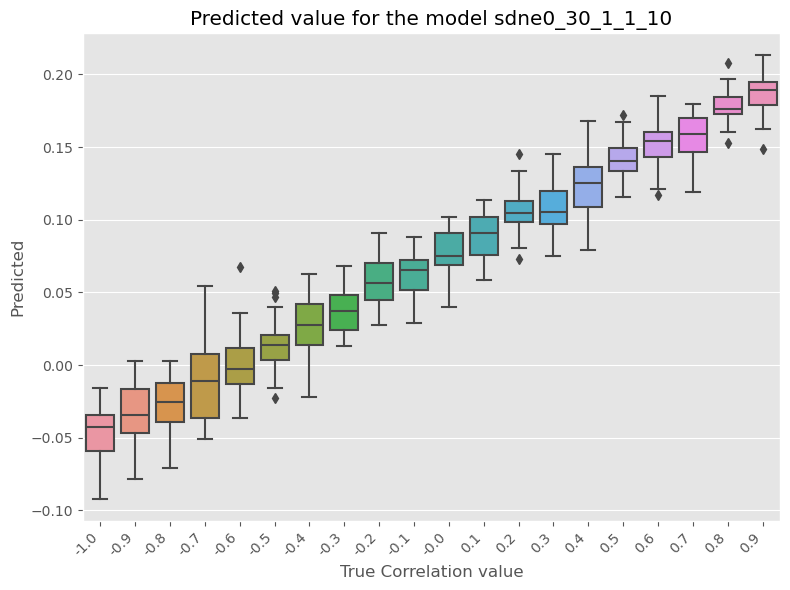

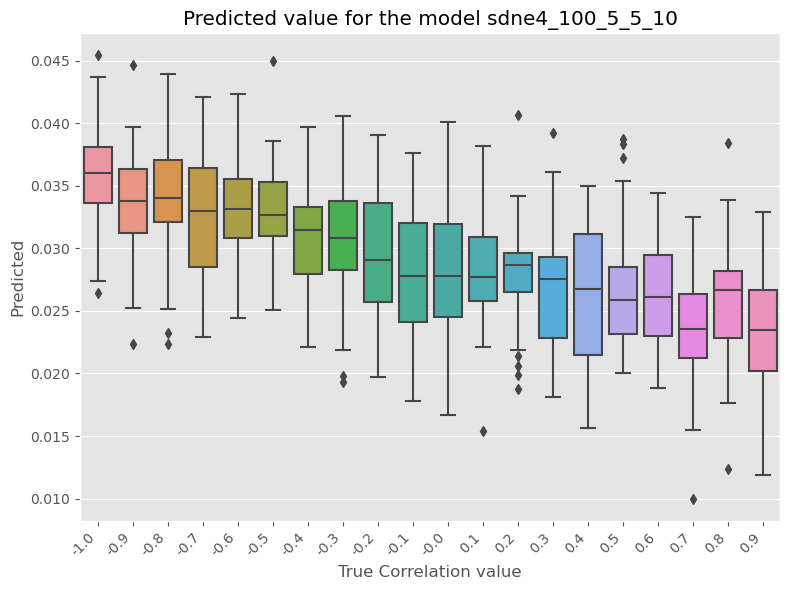

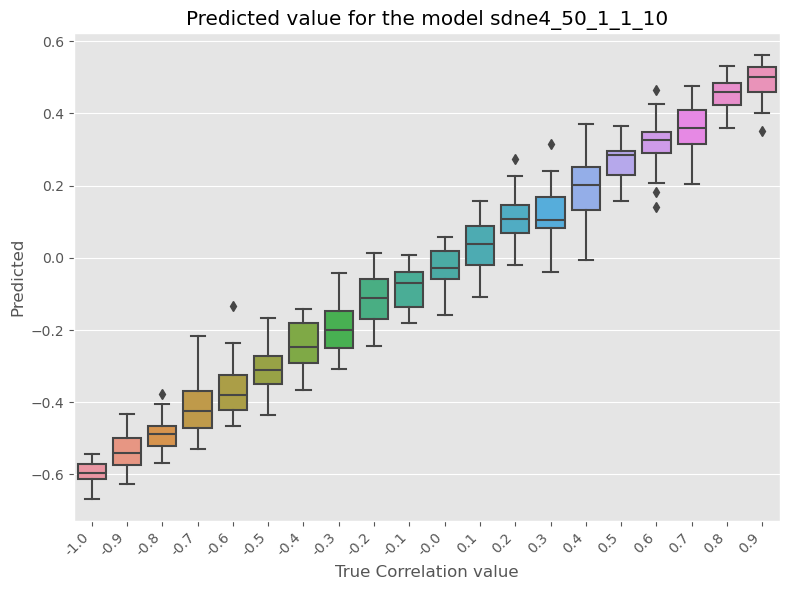

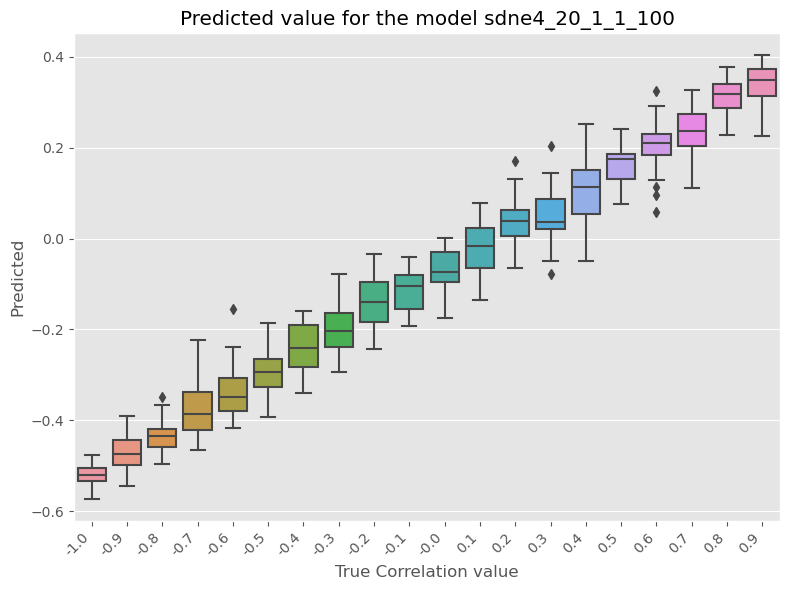

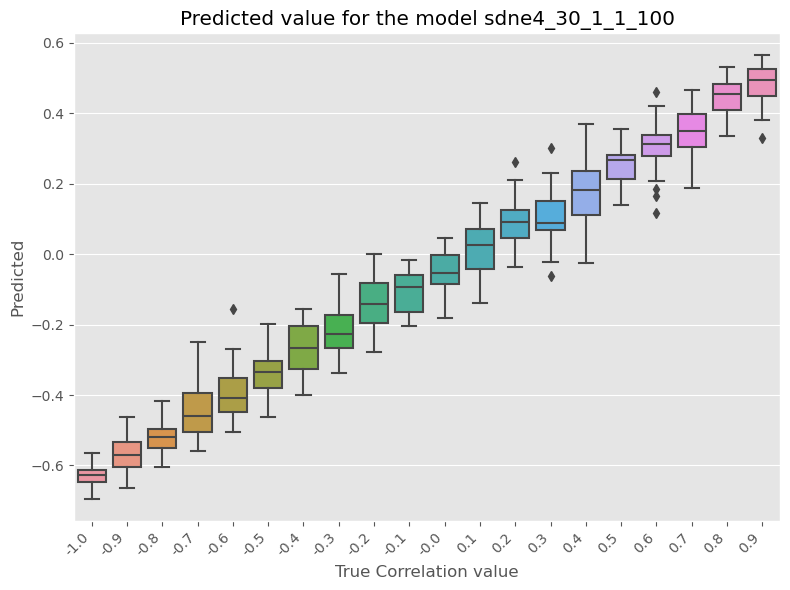

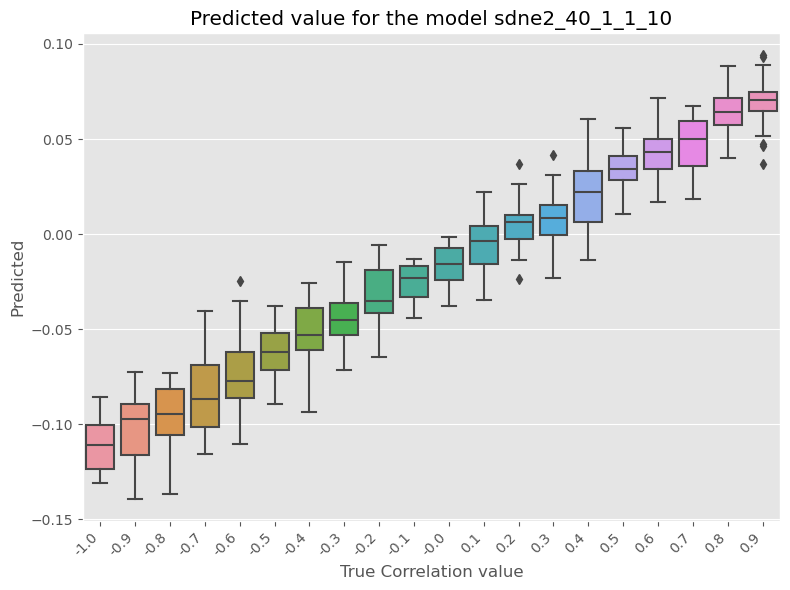

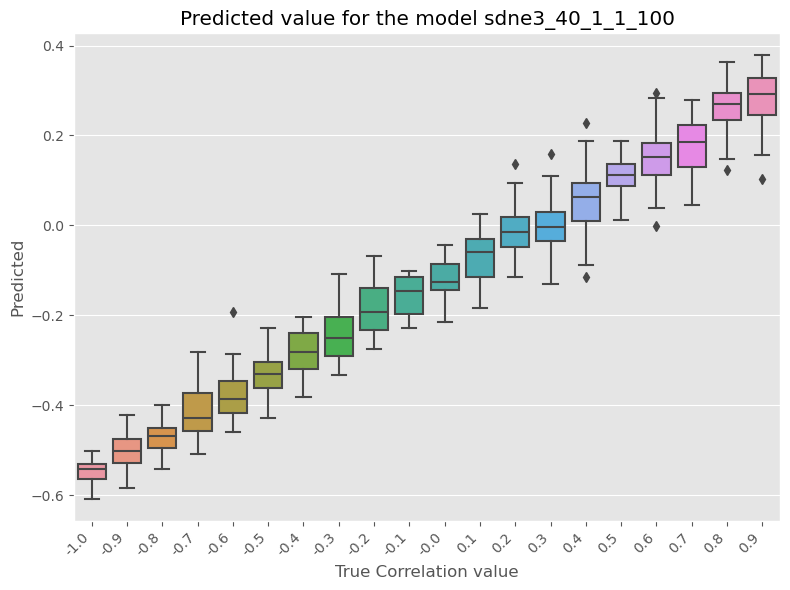

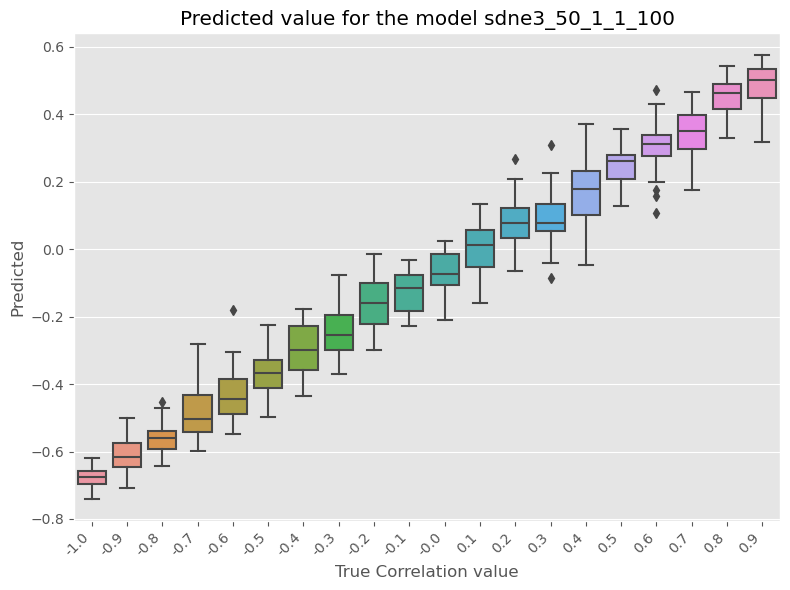

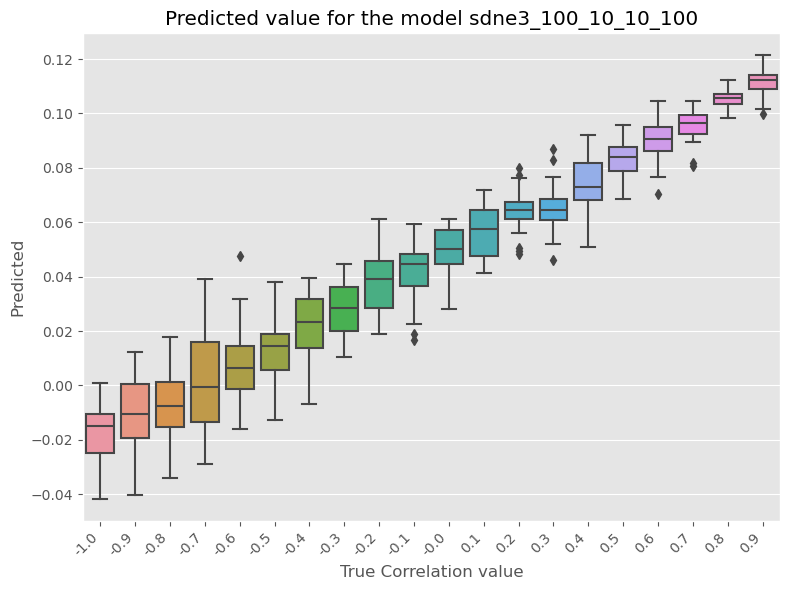

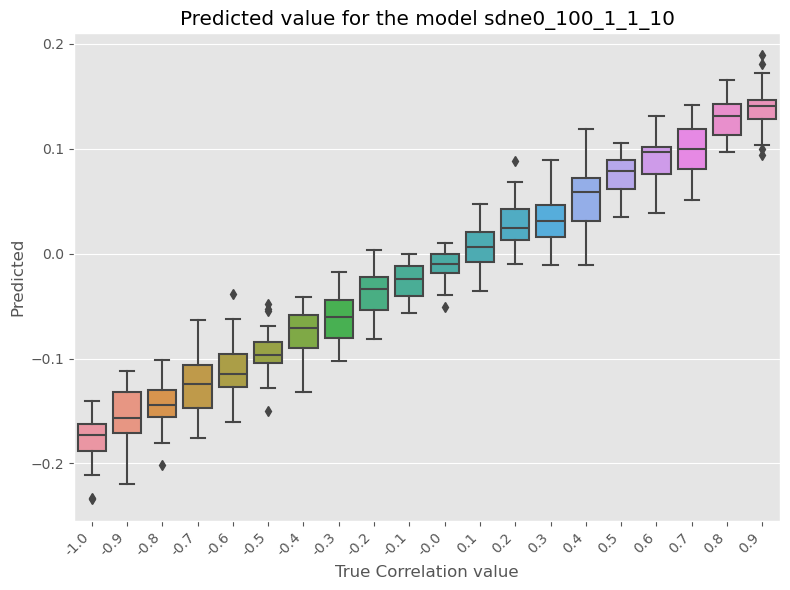

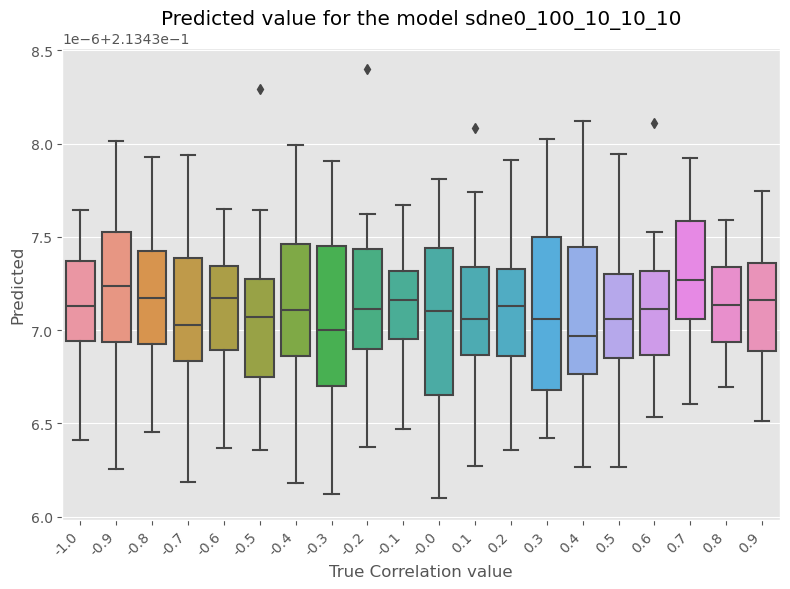

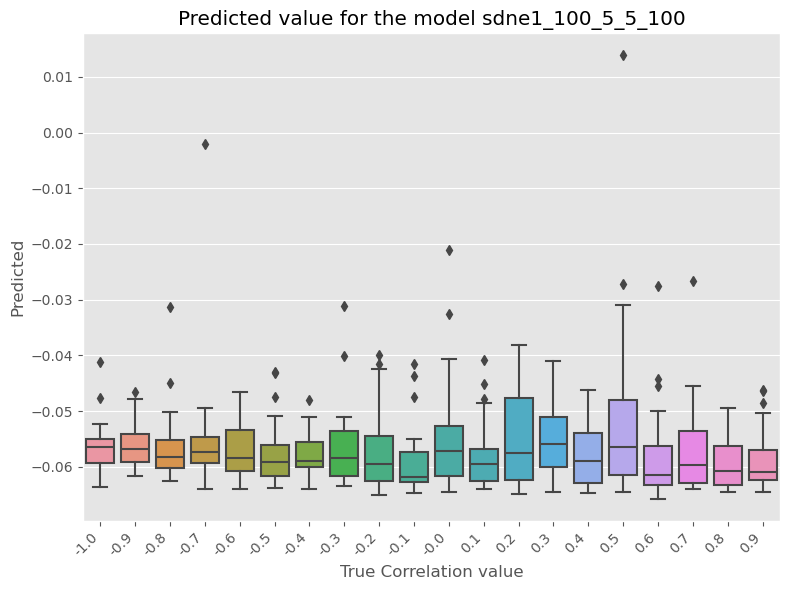

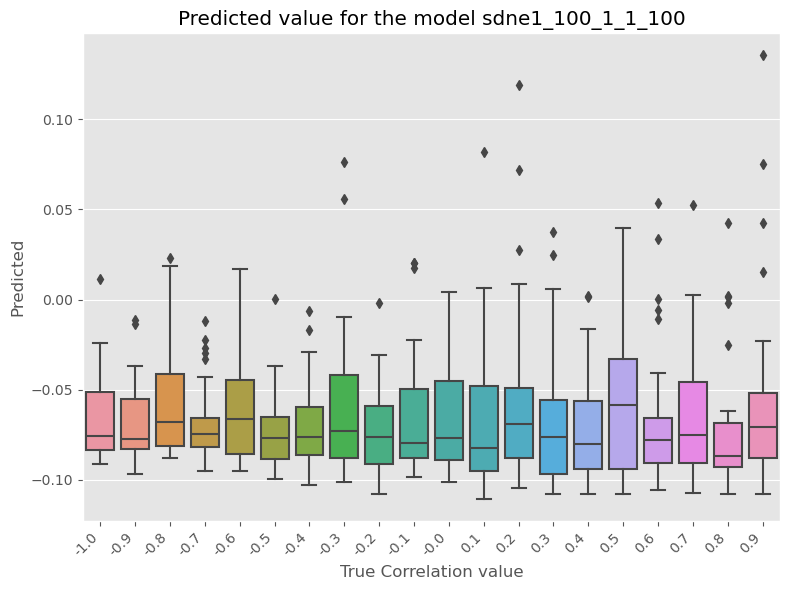

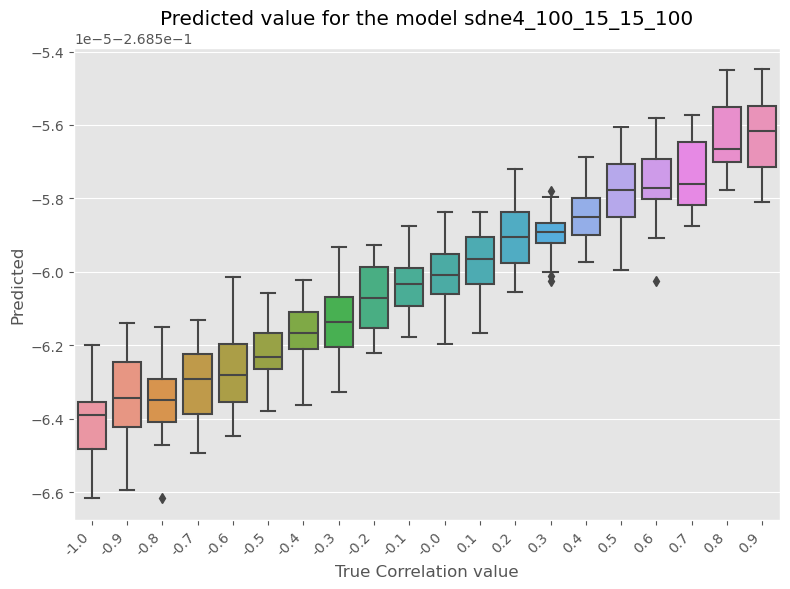

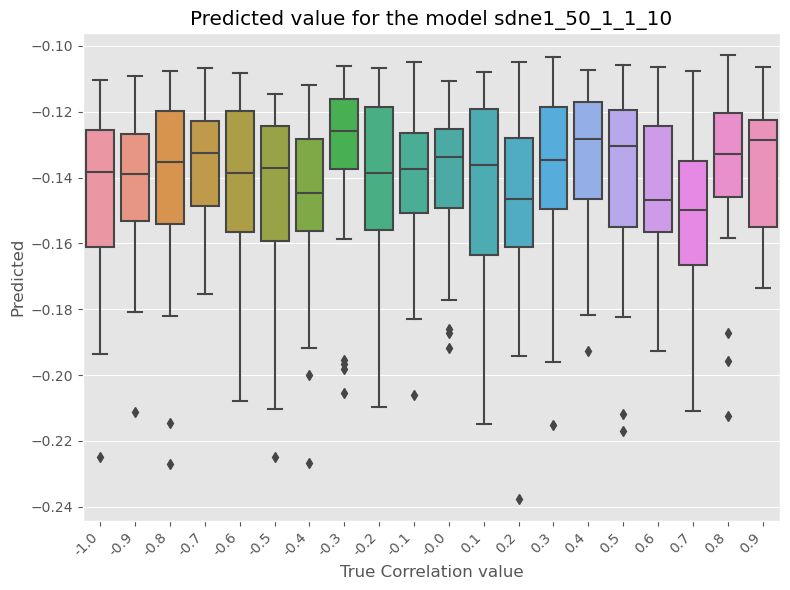

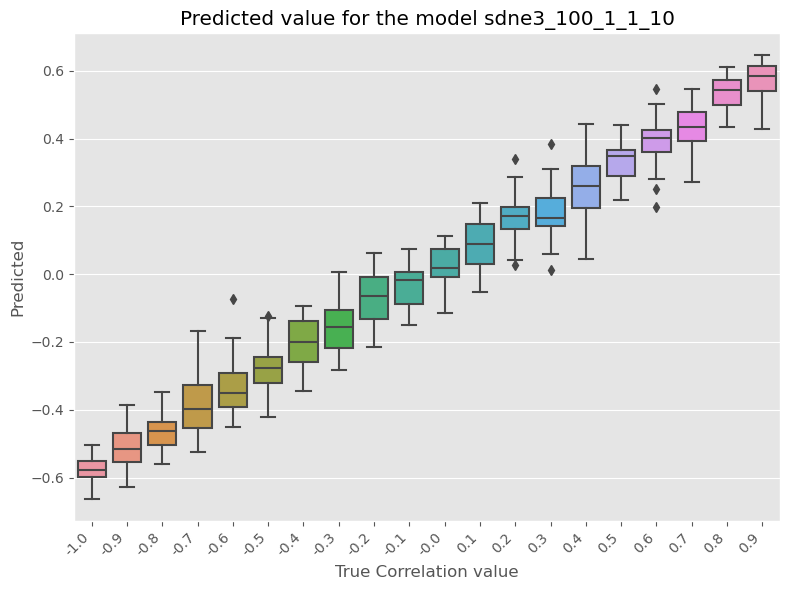

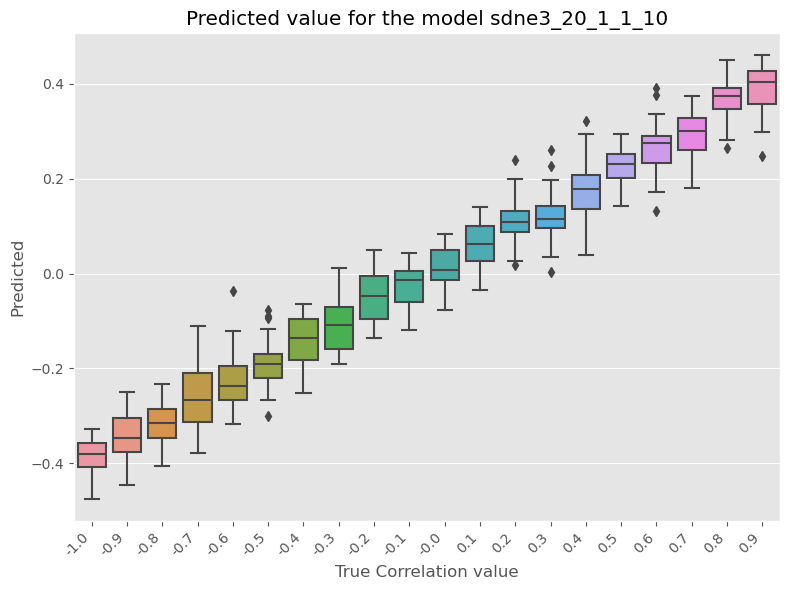

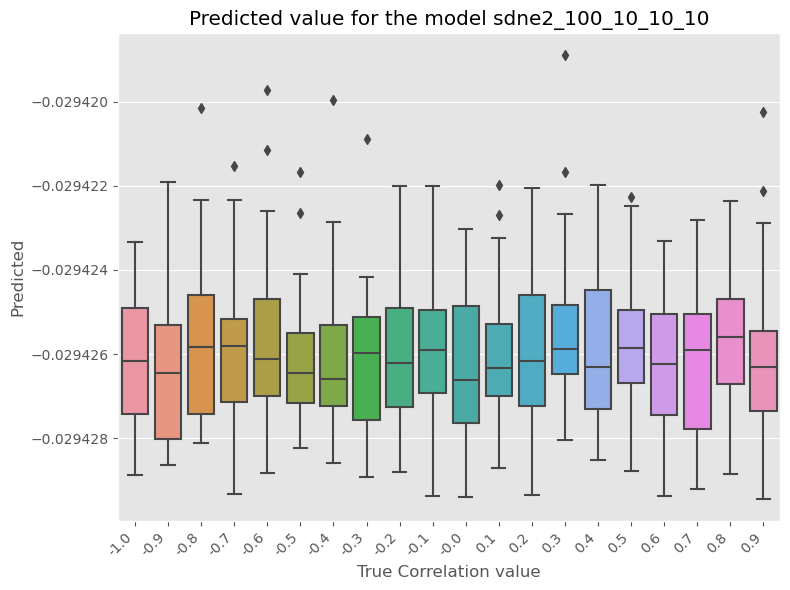

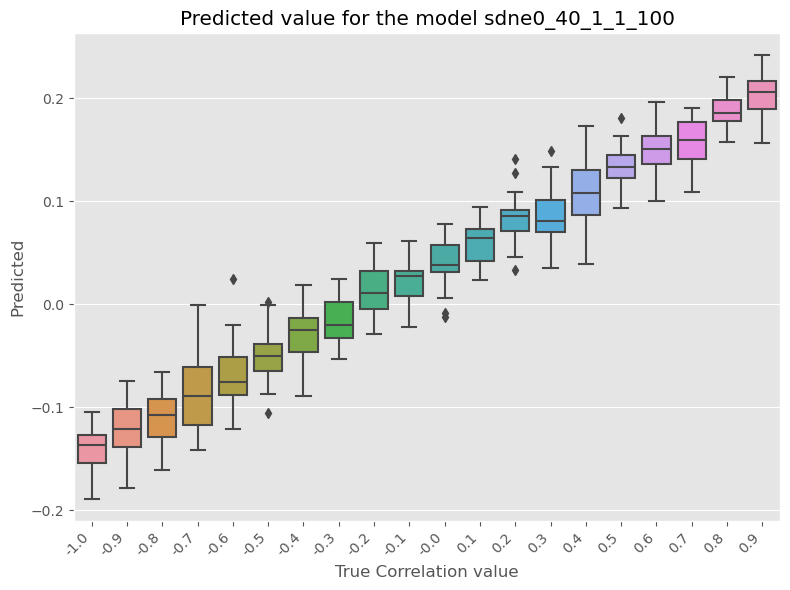

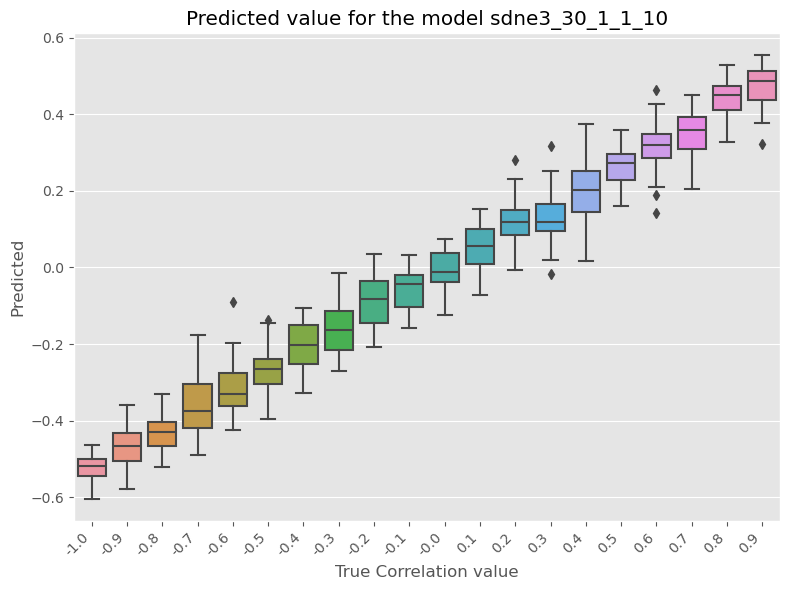

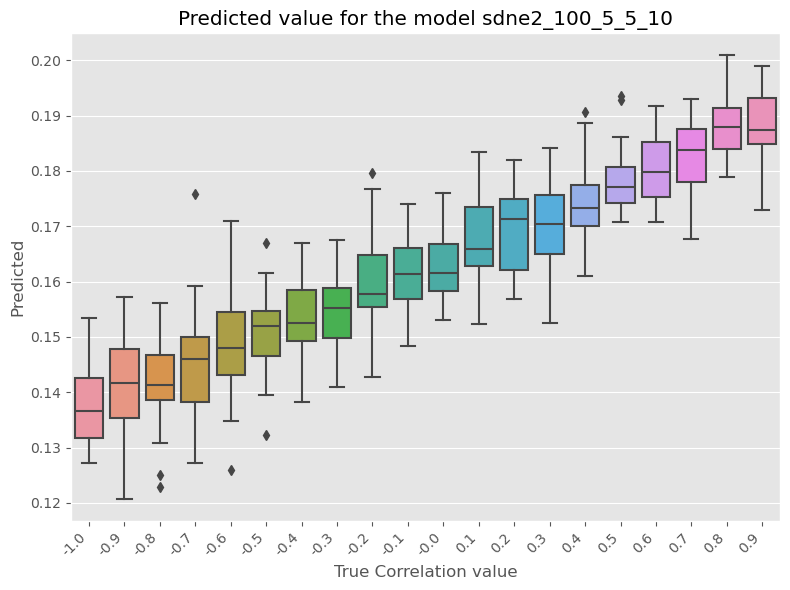

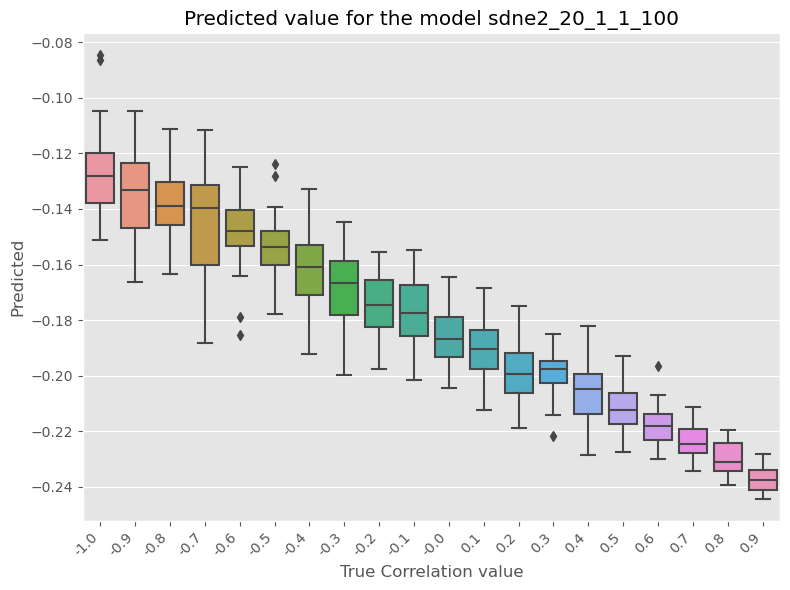

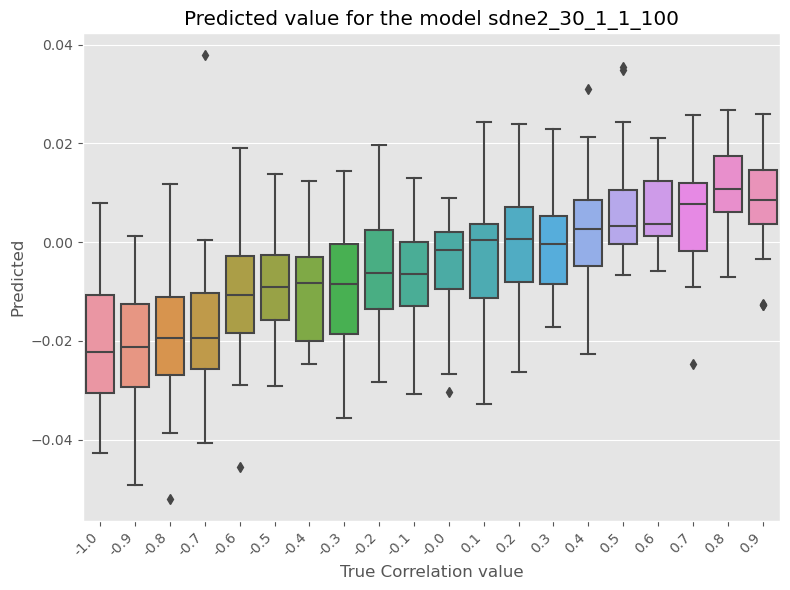

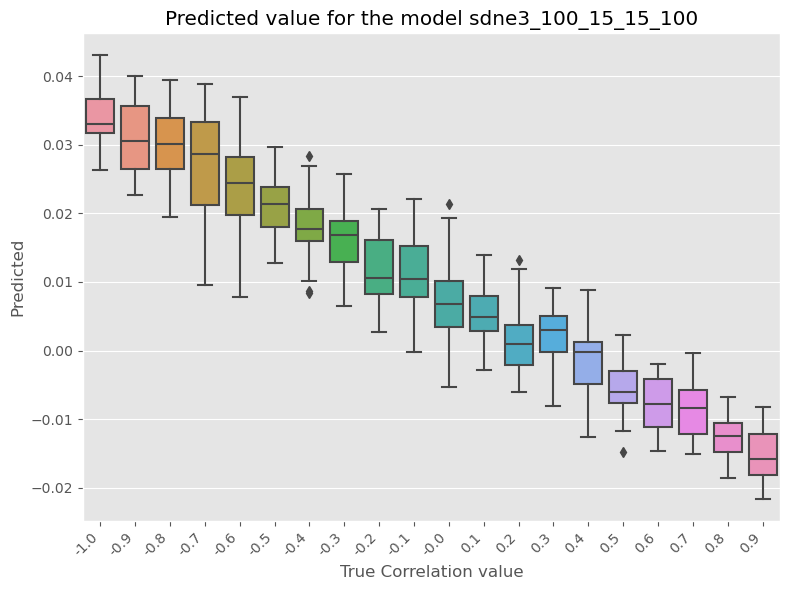

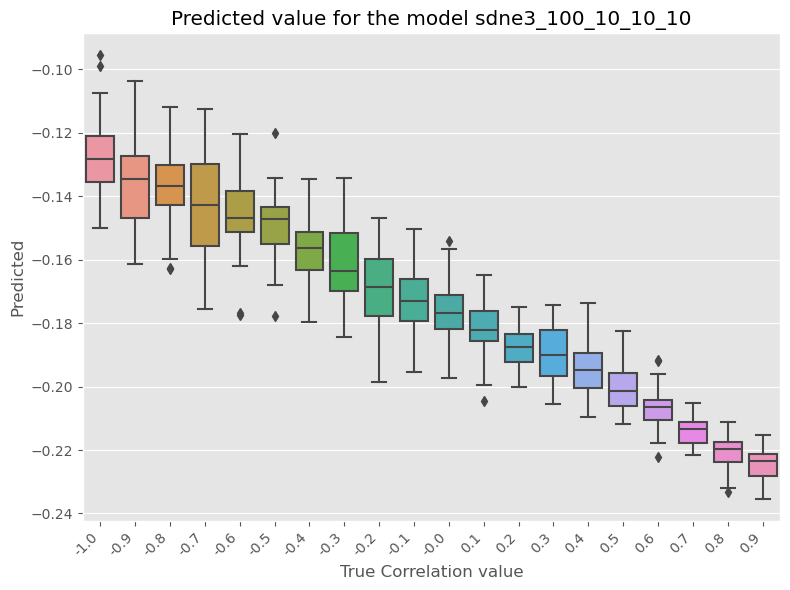

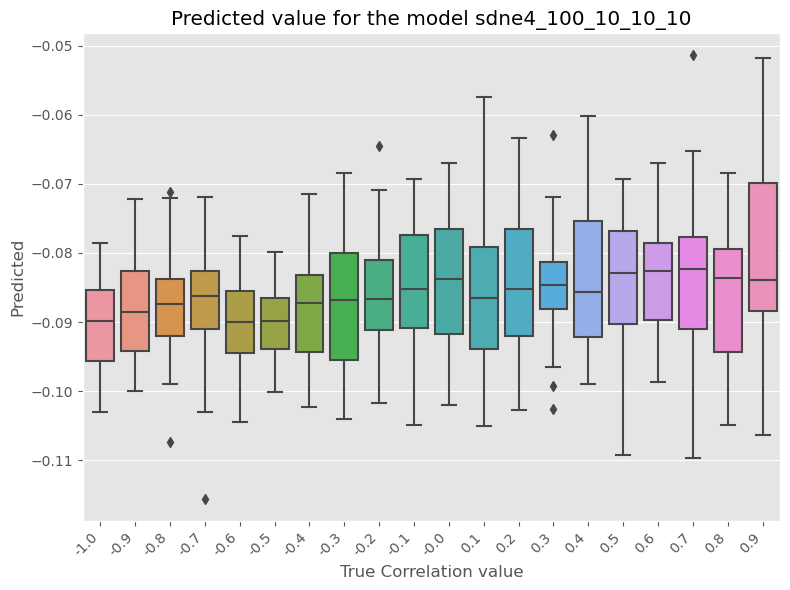

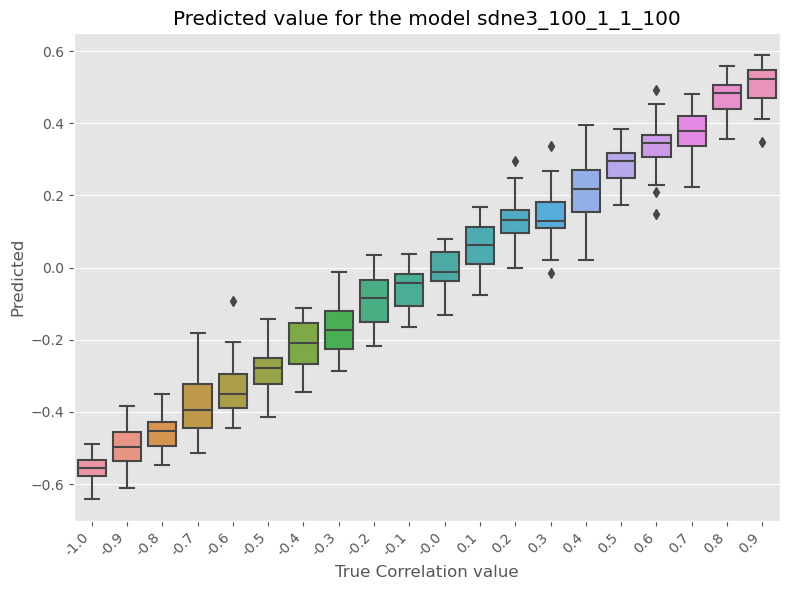

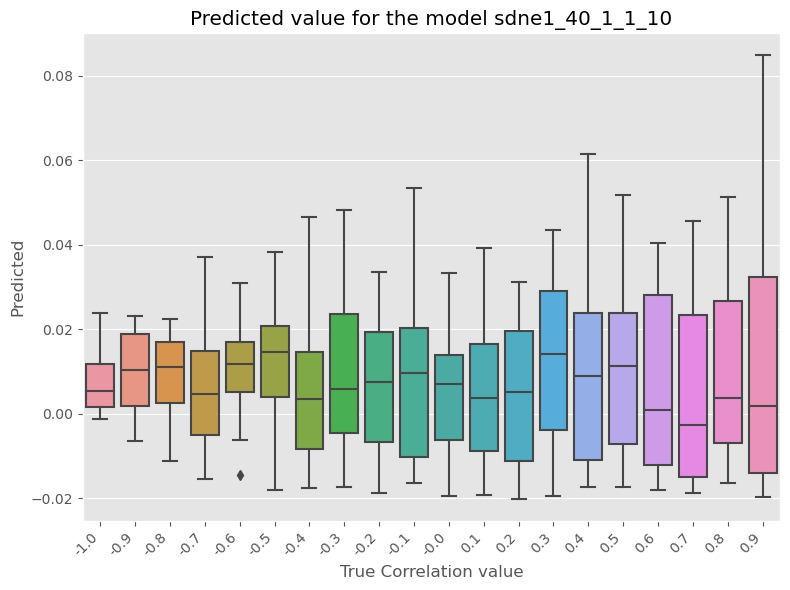

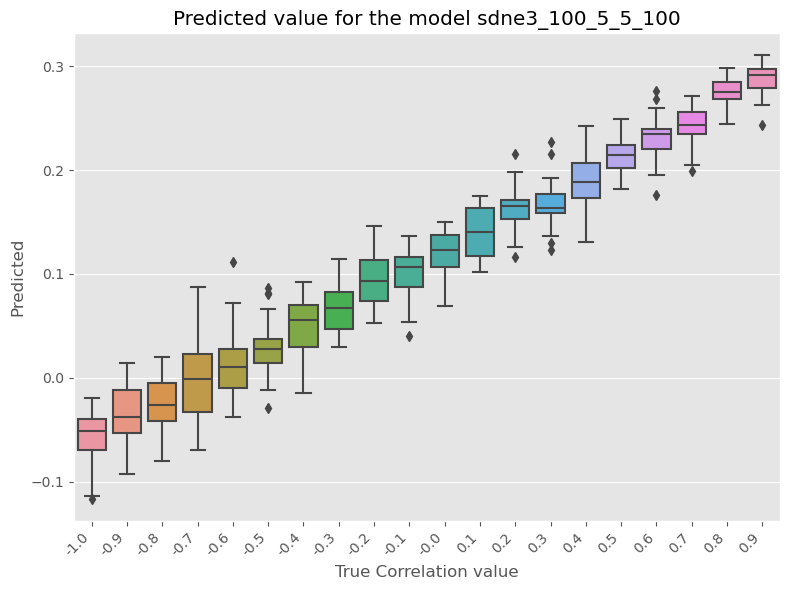

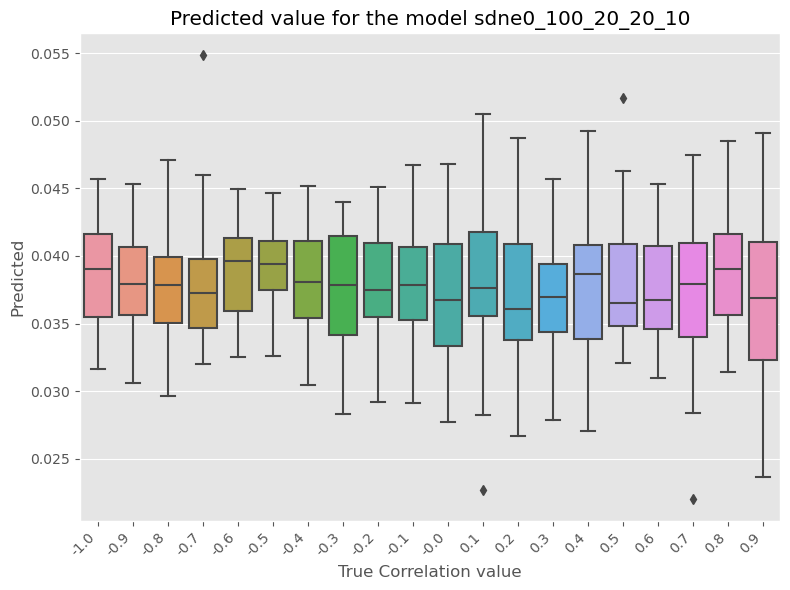

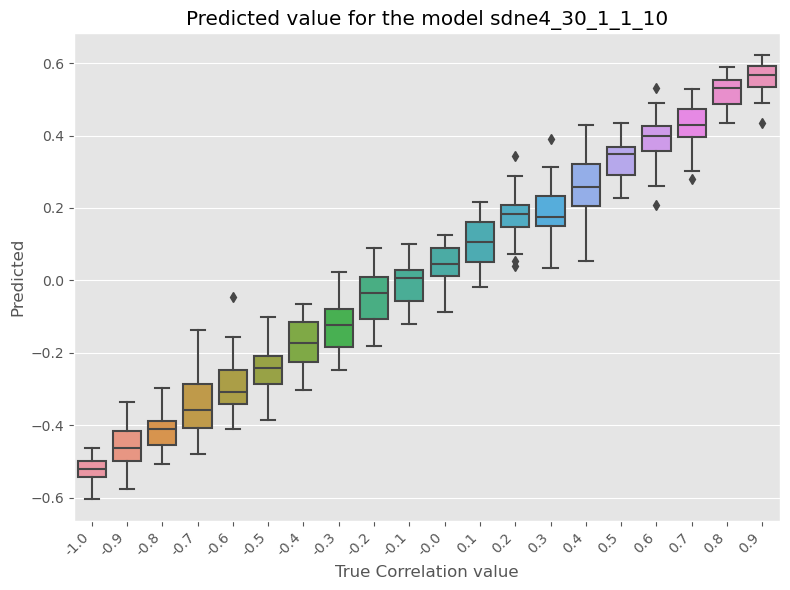

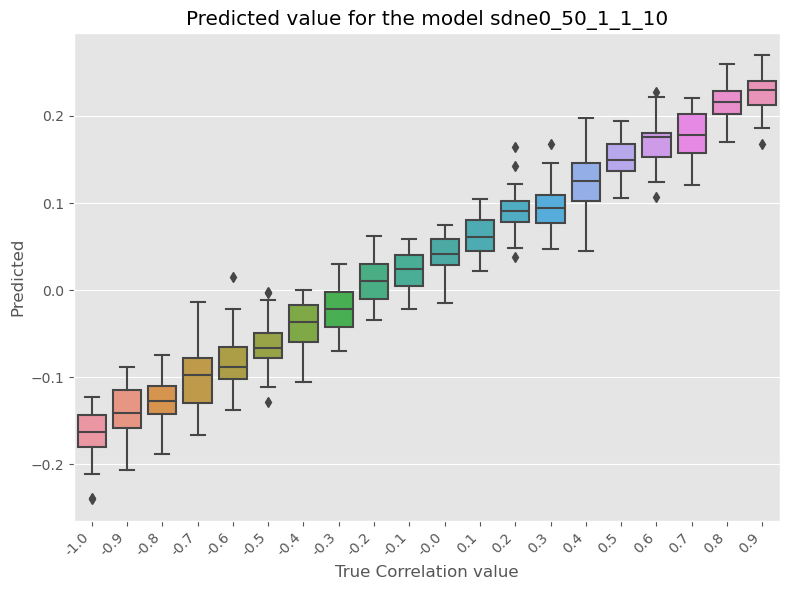

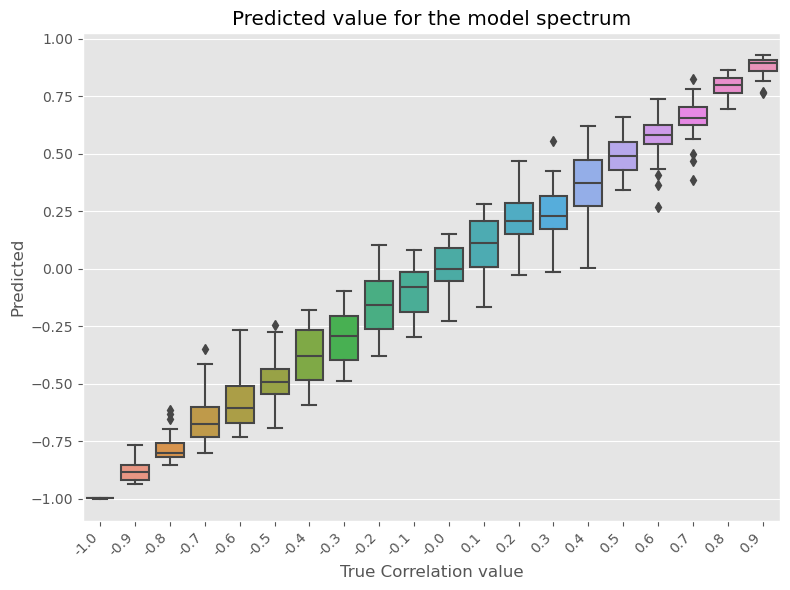

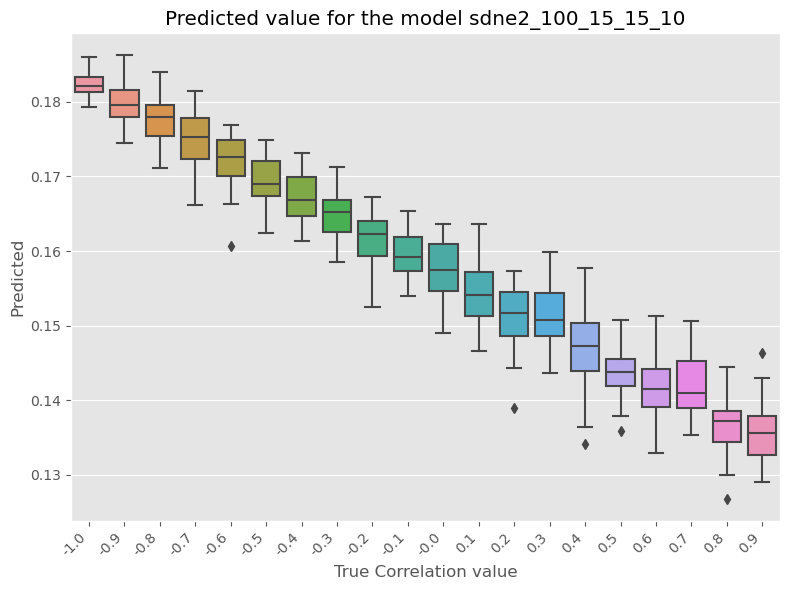

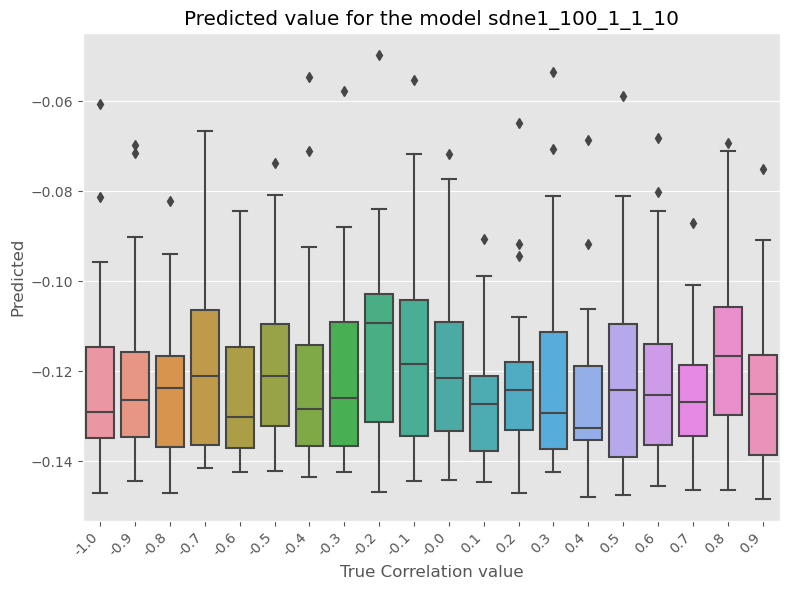

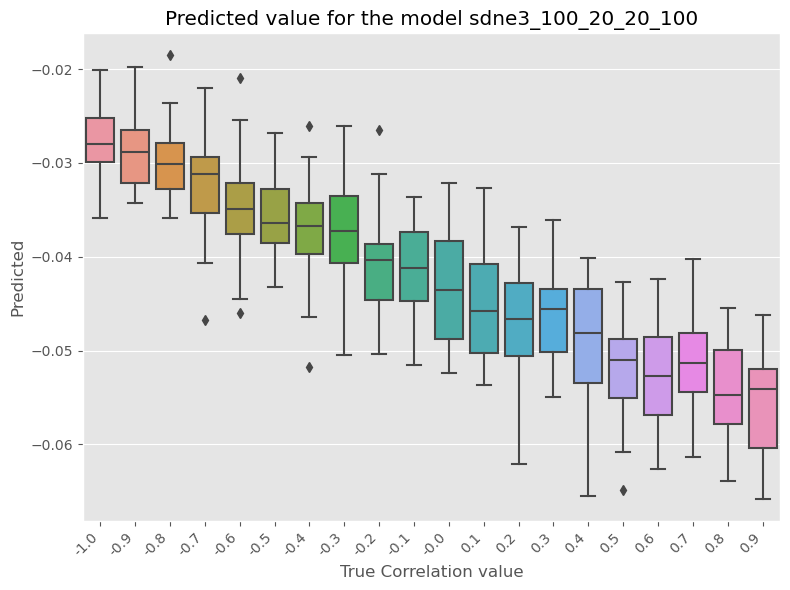

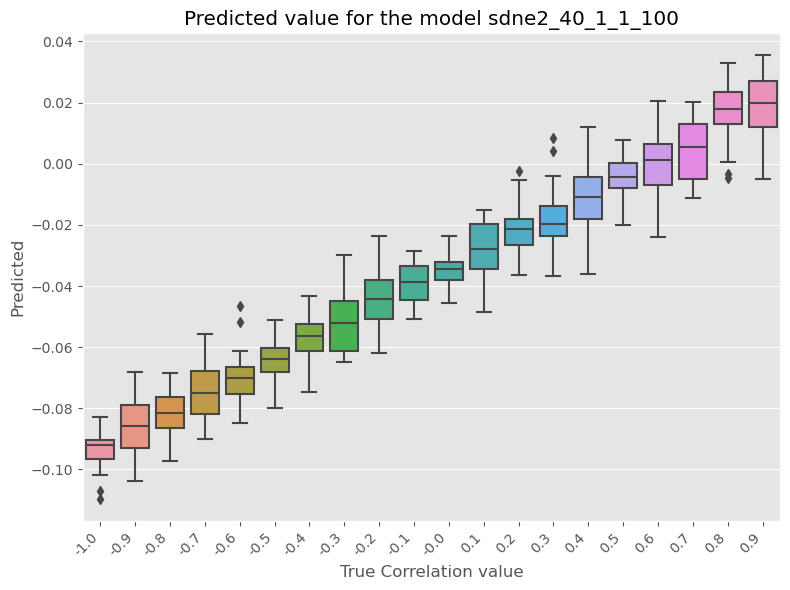

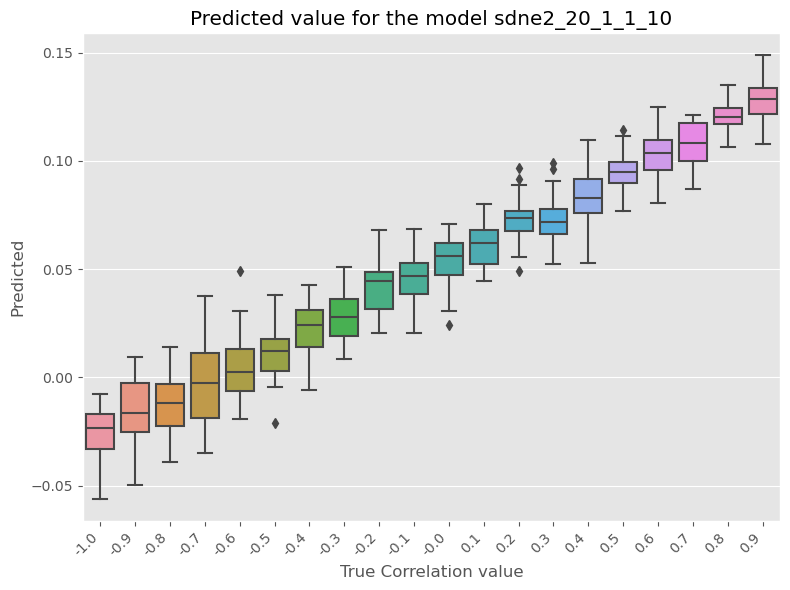

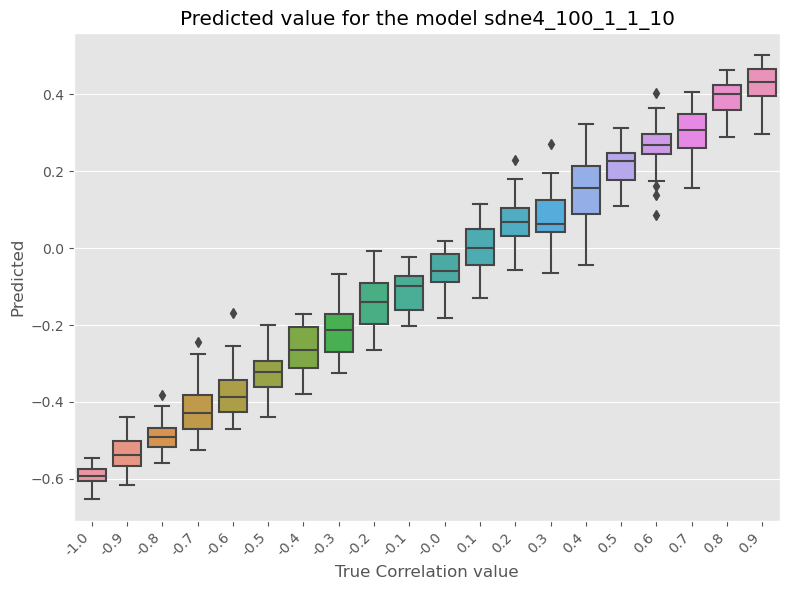

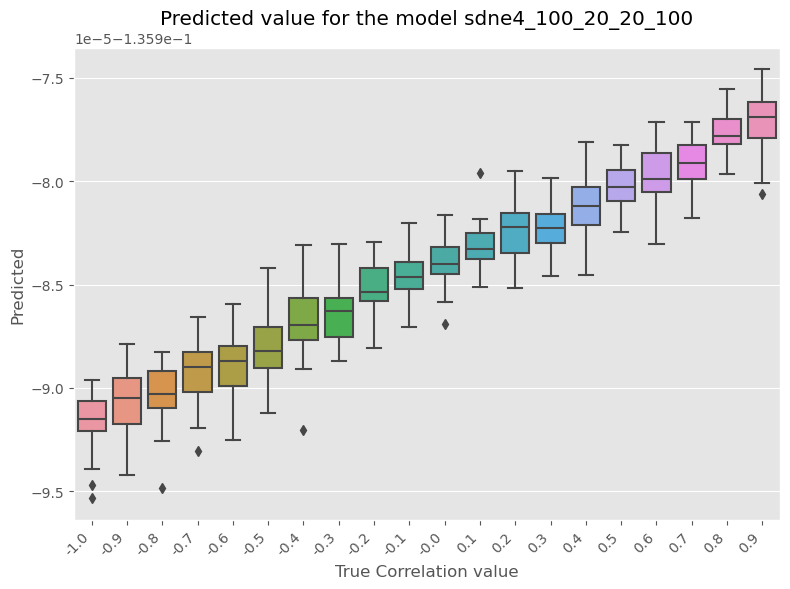

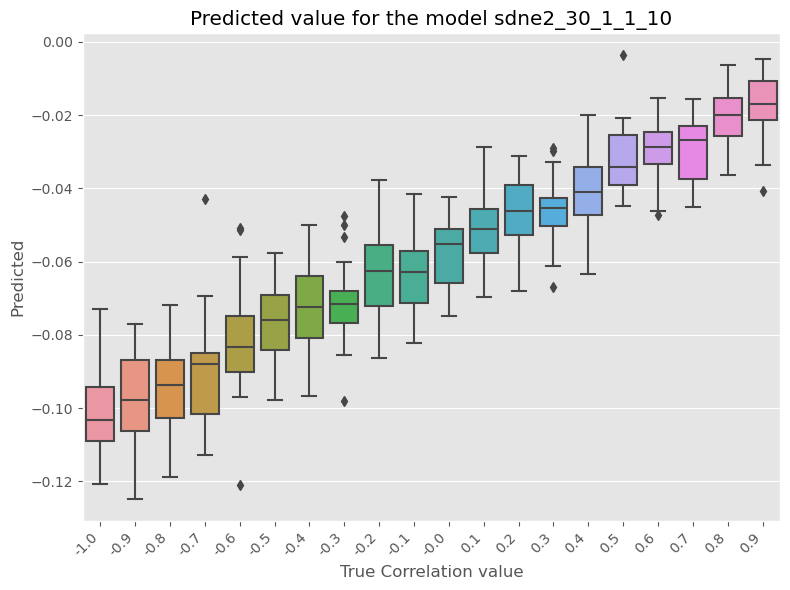

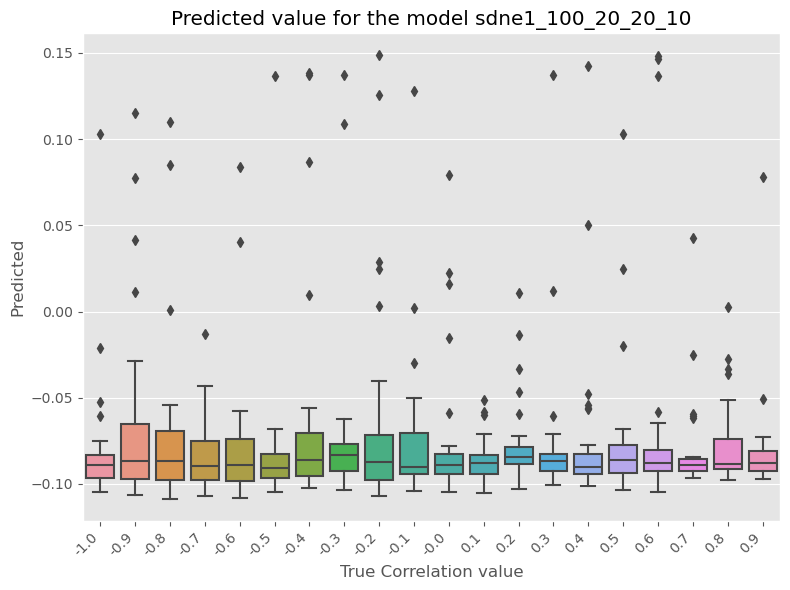

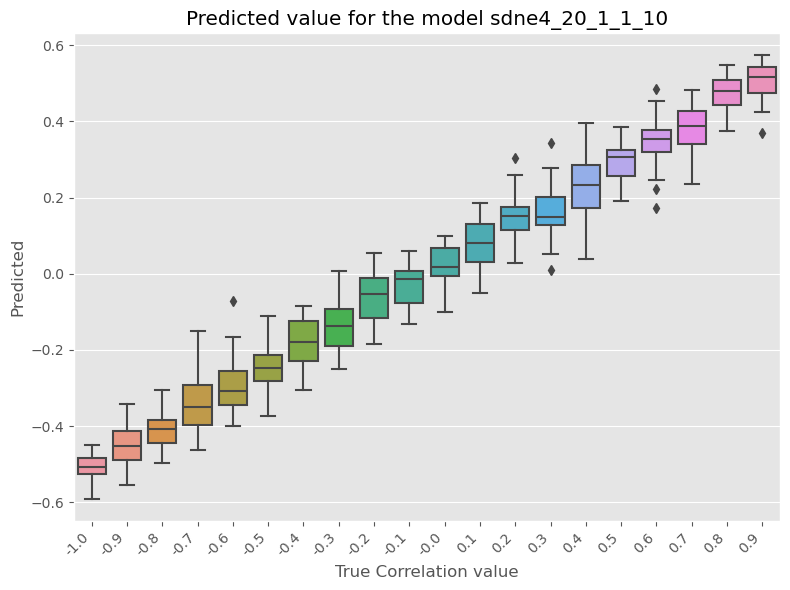

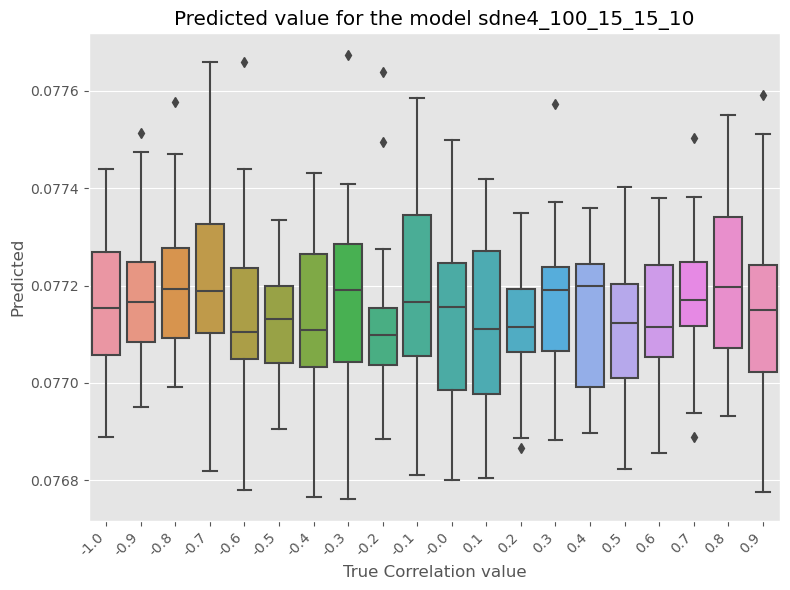

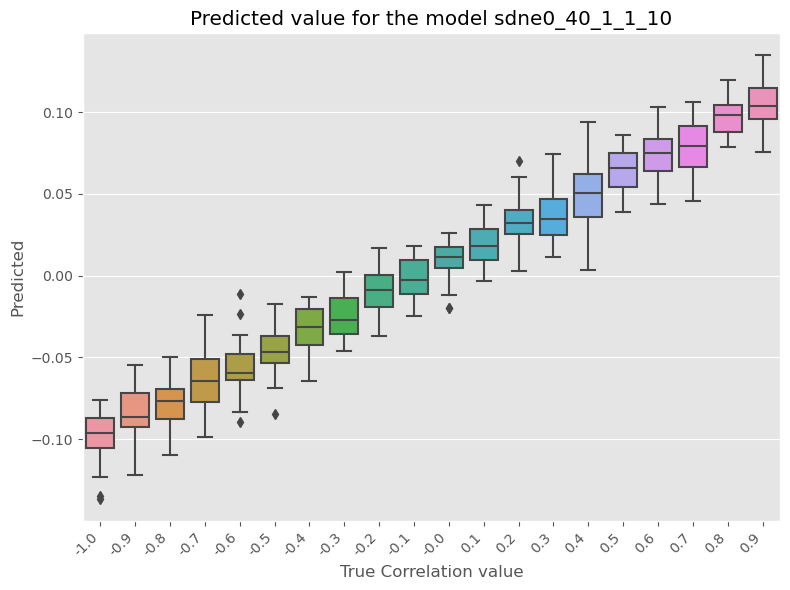

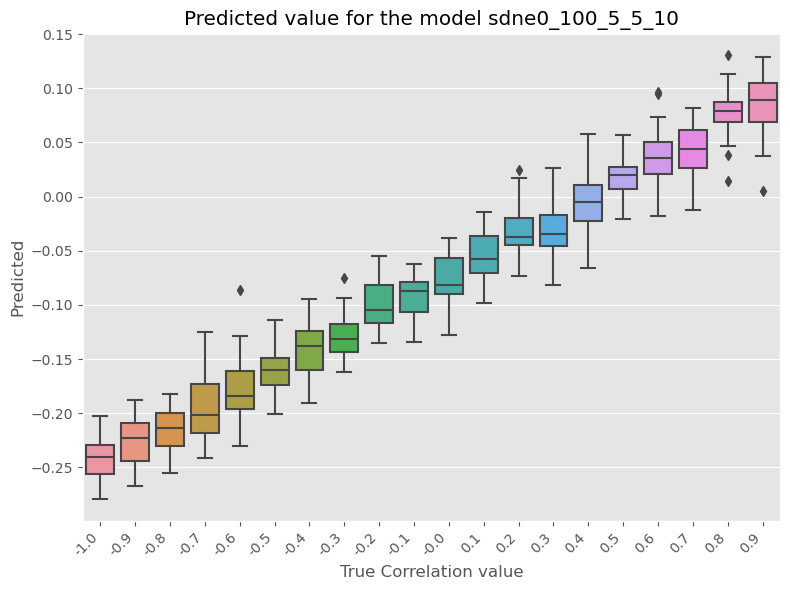

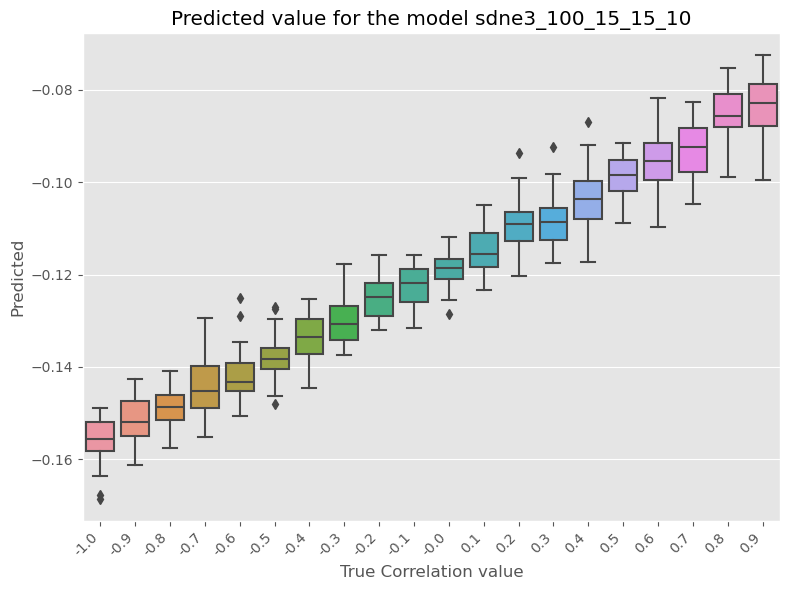

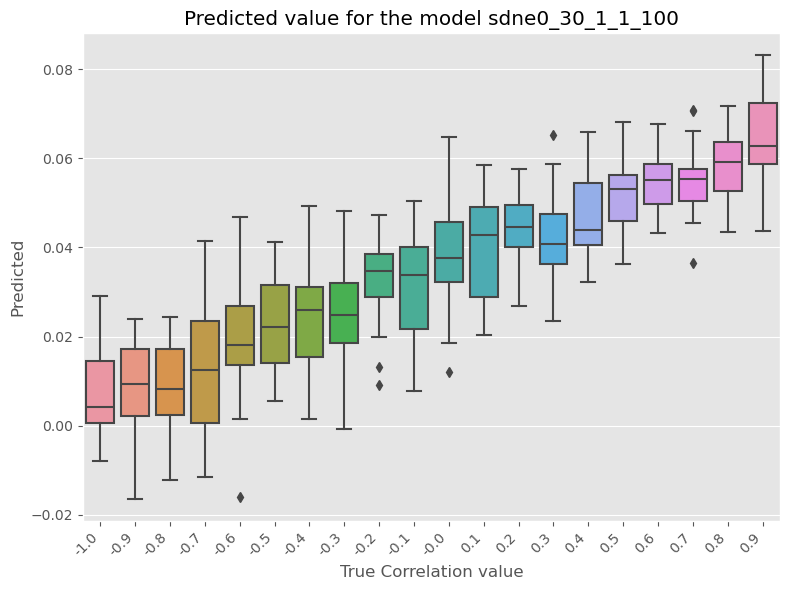

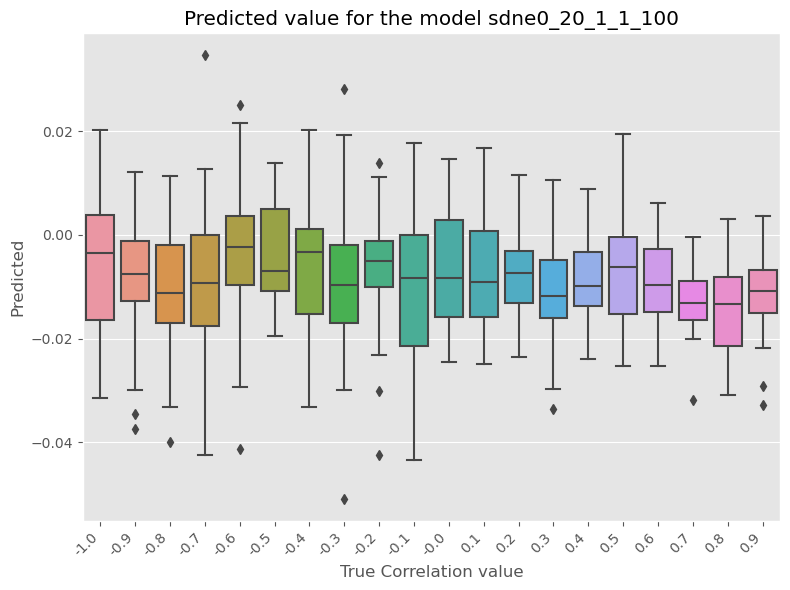

In [24]:
for model in all_diff_by_true_cov_df["model"].unique():
    model_df = all_diff_by_true_cov_df[all_diff_by_true_cov_df["model"] == model]
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="true", y="pred", data=model_df)
    plt.title(f'Predicted value for the model {model}')
    plt.xlabel('True Correlation value')
    plt.ylabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Simulation 1b

### Dataset

For each covariance in a list of different covariances between graph pairs, for n in a list of the number of nodes (10 to 100, 10 by 10), we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

In [25]:
dataset = "simulation1a"
n_nodes = os.listdir(os.path.join(outputs_path, dataset))
n_nodes_agg_metrics = []
for n in n_nodes:
    models = os.listdir(os.path.join(outputs_path, dataset, n))
    for model in models:

        # load data
        data = load_pickle(os.path.join(outputs_path, dataset, n, model, 'results.pkl'))

        try:
            if model == 'spectrum':
                test_data = data["train_test_results"]
            else:
                test_data = data["test_results"]
        except:
            print(model, n)

        test_data_df = []
        for i in range(test_data.shape[0]):
            simulation_test_data = test_data[i, :, :]
            simulation_test_data_df = pd.DataFrame(simulation_test_data.numpy(), columns=["pred", "true"])
            simulation_test_data_df.loc[:, "simulation"] = i

            test_data_df.append(simulation_test_data_df)
        test_data_df = pd.concat(test_data_df, axis=0)
        test_data_df.loc[:, "true"] = [round(x, 2) for x in test_data_df["true"]]
        test_data_df.loc[:, "model"] = model
        all_test_data.append(test_data_df)

        # compute aggregated mse and mae
        mse = mean_squared_error(test_data_df["true"], test_data_df["pred"])
        mae = mean_absolute_error(test_data_df["true"], test_data_df["pred"])
        n_nodes_agg_metrics.append({"model": model, "n_nodes": n, "mse": mse, "mae": mae})
n_nodes_agg_metrics_df = pd.DataFrame(n_nodes_agg_metrics)

NotADirectoryError: [Errno 20] Not a directory: '/Users/danieloliveira/Documents/Daniel/codes/graph-corr-embedd/src/data/outputs/simulation1a/sdne3_50_1_1_10/training_info.pkl/results.pkl'

In [57]:
n_nodes_agg_metrics_df

model n_nodes       mse       mae
0   sdne_100_20_20      50  0.345196  0.508232
1         spectrum      50  0.066802  0.190939
2      sdne_20_1_1      50  0.191831  0.372227
3   sdne_100_20_20      10  0.393236  0.529414
4         spectrum      10  0.076295  0.214501
5      sdne_20_1_1      10  0.664162  0.667618
6   sdne_100_20_20     100  0.344832  0.504871
7         spectrum     100  0.071269  0.195152
8      sdne_20_1_1     100  0.202767  0.387734
9   sdne_100_20_20     500  0.346215  0.506763
10        spectrum     500  0.061760  0.183848
11     sdne_20_1_1     500  0.196538  0.381543
12  sdne_100_20_20    1000  0.152383  0.332302
13        spectrum    1000  0.270300  0.381000
14     sdne_20_1_1    1000  0.207950  0.394126
15  sdne_100_20_20     200  0.334401  0.501300
16        spectrum     200  0.067065  0.189182
17     sdne_20_1_1     200  0.190813  0.379990

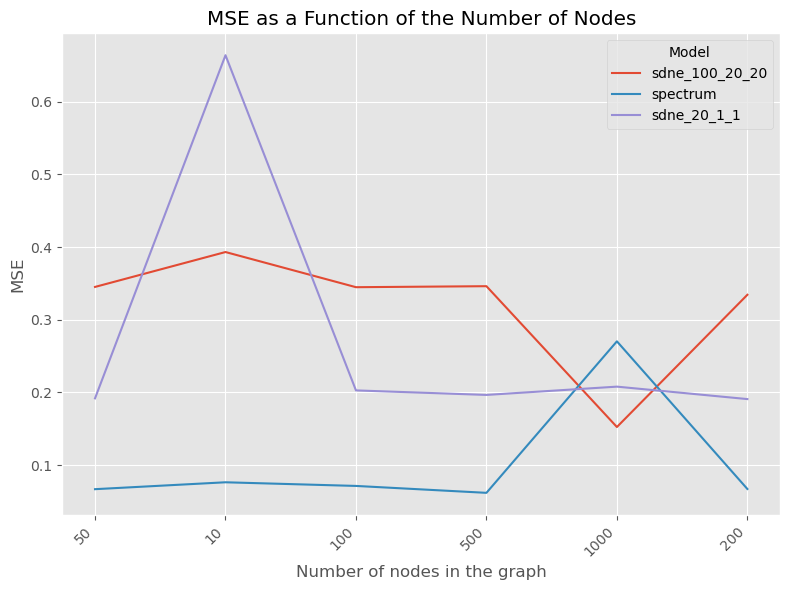

In [70]:
colors = ['red', 'green', 'blue', 'purple']  # Define a color for each line

plt.figure(figsize=(8, 6))  # Create a figure for the plots

sns.lineplot(data=n_nodes_agg_metrics_df, x="n_nodes", y="mse", hue="model")

plt.title('MSE as a Function of the Number of Nodes')  # Set the title for the entire plot
plt.xlabel('Number of nodes in the graph')  # Set the x-axis label
plt.ylabel('MSE')  # Set the y-axis label
plt.legend(title='Model')  # Enable the legend to distinguish models

# Rotate x labels for better fit
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
dataset_name = "simulation1c"
simulation_names = os.listdir(os.path.join(outputs_path, dataset_name))


all_metrics = []
for simulation_name in simulation_names:
    for model in os.listdir(os.path.join(outputs_path, dataset_name, simulation_name)):

        if 'spectrum' in model:
            data = load_pickle(os.path.join(outputs_path, dataset_name, simulation_name, model, 'results.pkl'))
            test_data = data["train_test_results"]
        else:
            data = load_pickle(os.path.join(outputs_path, dataset_name, simulation_name, model, 'predictions.pkl'))
            test_data = data["test_predictions"]

        if len(test_data.shape) > 2:
            test_data_df = []
            for i in range(test_data.shape[0]):
                simulation_test_data = test_data[i, :, :]
                simulation_test_data_df = pd.DataFrame(simulation_test_data.numpy(), columns=["pred", "true"])
                simulation_test_data_df.loc[:, "simulation"] = i

                test_data_df.append(simulation_test_data_df)
            test_data_df = pd.concat(test_data_df, axis=0)
            test_data_df.loc[:, "true"] = [round(x, 2) for x in test_data_df["true"]]
            test_data_df.loc[:, "model"] = model
        else:
            test_data_df = pd.DataFrame(test_data.numpy(), columns=["pred", "true"])
            test_data_df.loc[:, "true"] = [round(x, 2) for x in test_data_df["true"]]
            test_data_df.loc[:, "model"] = model


        # compute aggregated mse and mae
        mse = mean_squared_error(test_data_df["true"], test_data_df["pred"])
        mae = mean_absolute_error(test_data_df["true"], test_data_df["pred"])

        tmp_metrics = pd.DataFrame({"dataset": dataset_name,
                                    "simulation": simulation_name,
                                    "model": model,
                                    "mse": mse,
                                "mae": mae}, index=[0])
        all_metrics.append(tmp_metrics)
all_metrics_df = pd.concat(all_metrics, axis=0)

all_metrics_df

dataset      simulation             model       mse       mae
0  simulation1c     erdos_renyi             sdne3  0.108179  0.285429
0  simulation1c     erdos_renyi  sdne7_100_1_1_10  0.248597  0.431693
0  simulation1c     erdos_renyi  sdne1_50_1_1_100  0.273705  0.452443
0  simulation1c     erdos_renyi          spectrum  0.012156  0.080622
0  simulation1c     erdos_renyi  sdne7_50_1_1_100  0.216818  0.403414
0  simulation1c  watts_strogatz             sdne3  0.329169  0.497530
0  simulation1c  watts_strogatz          spectrum  0.114484  0.269591
0  simulation1c  watts_strogatz  sdne7_50_1_1_100  0.333978  0.499533